In [2]:
pip install imbalanced-learn


In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

def collect_and_clean_data(file_path):
    # Load data
    data = pd.read_csv(file_path)

    # Print columns to check their names
    print("Columns in dataset:", data.columns.tolist())

    # Clean column names
    data.columns = data.columns.str.strip()  # Remove leading/trailing whitespace
    data.columns = data.columns.str.replace('\xa0', ' ')  # Replace non-breaking spaces

    # Clean data entries
    for col in data.columns:
        if data[col].dtype == 'object':  # Apply only to string columns
            data[col] = data[col].str.strip()  # Remove leading/trailing whitespace
            data[col] = data[col].str.replace('\xa0', ' ')  # Replace non-breaking spaces

    # Handle non-numeric values in numeric columns
    for col in data.columns:
        if data[col].dtype == 'object':
            try:
                # Attempt to convert to numeric
                data[col] = pd.to_numeric(data[col], errors='coerce')
            except ValueError:
                # If there's a ValueError, it's likely non-numeric data present
                pass

        # Replace non-numeric (NaN) values with the average of the above and below cells
        if data[col].dtype in ['float64', 'int64']:
            data[col] = data[col].interpolate(method='linear', limit_direction='both')

    # Handle missing values (if any remain after interpolation)
    data = data.dropna()  # Optionally use data.fillna() for different handling

    # Print columns after missing value handling
    print("Columns after missing value handling:", data.columns.tolist())

    # Normalize numerical features
    numerical_features = ['Age(yrs)', 'BMI', 'TSH (mIU/L)']

    # Check if numerical features exist
    for feature in numerical_features:
        if feature not in data.columns:
            print(f"Warning: '{feature}' not found in dataset.")

    # Apply normalization if features are present
    existing_numerical_features = [feature for feature in numerical_features if feature in data.columns]
    if existing_numerical_features:
        scaler = MinMaxScaler()
        data[existing_numerical_features] = scaler.fit_transform(data[existing_numerical_features])

    # Manage categorical variables
    categorical_features = ['Blood Group']  # Only one-hot encode necessary columns
    data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

    # Print columns after one-hot encoding
    print("Columns after one-hot encoding:", data.columns.tolist())

    # Check class imbalance
    target_variable = 'PCOS (Y/N)'  # Replace with your actual target variable name
    if target_variable in data.columns:
        print("Class distribution before handling imbalance:")
        print(data[target_variable].value_counts())

        # Separate majority and minority classes
        majority_class = data[data[target_variable] == 0]
        minority_class = data[data[target_variable] == 1]

        # Upsample minority class
        minority_upsampled = resample(minority_class,
                                      replace=True,     # Sample with replacement
                                      n_samples=len(majority_class),  # Match majority class
                                      random_state=42)  # Reproducible results

        # Combine majority class with upsampled minority class
        data = pd.concat([majority_class, minority_upsampled])

        # Shuffle the dataset
        data = data.sample(frac=1, random_state=42).reset_index(drop=True)

        print("Class distribution after handling imbalance:")
        print(data[target_variable].value_counts())

    else:
        print(f"Warning: '{target_variable}' not found in dataset. Skipping imbalance handling.")

    # Save cleaned data
    cleaned_dataset_path = 'cleaned_data.csv'
    data.to_csv(cleaned_dataset_path, index=False)

    print(f"Data collected and cleaned successfully. Cleaned data saved to '{cleaned_dataset_path}'")
    return data

# Example usage
file_path = '/content/PCOS_extended_dataset.csv'  # Replace with your actual file name
data = collect_and_clean_data(file_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/PCOS_extended_dataset.csv'

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='PCOS (Y/N)', data=data)  # Replace 'your_dataframe' with your actual DataFrame
plt.title("Distribution of PCOS Cases")
plt.show()


NameError: name 'data' is not defined

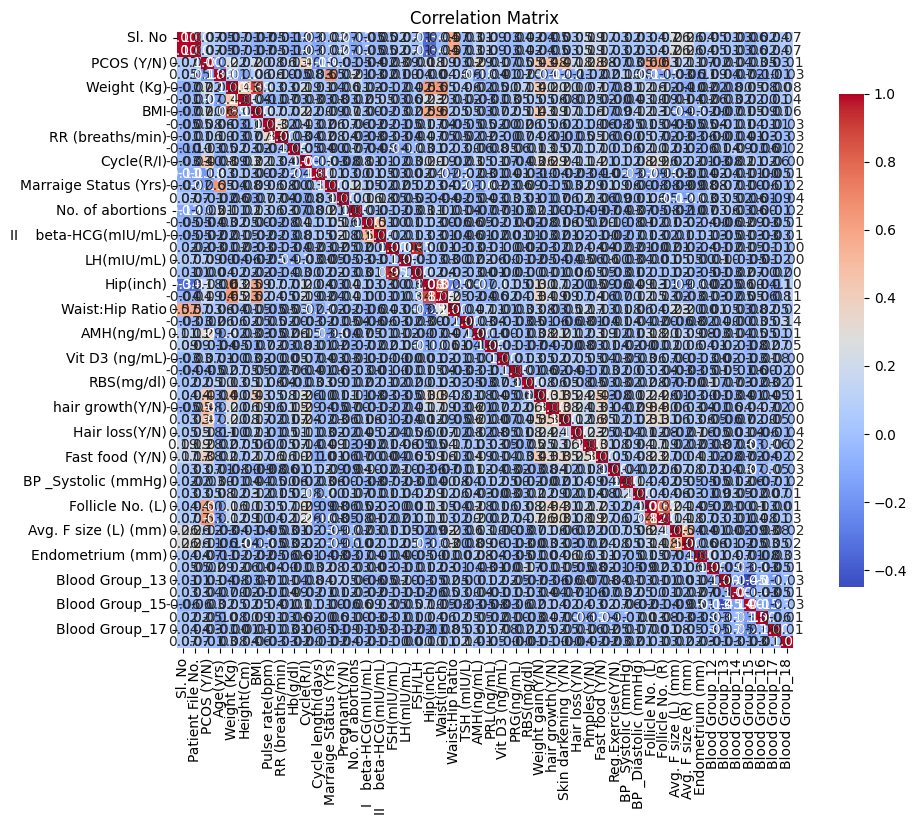

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned data
cleaned_data_path = 'cleaned_data.csv'  # Path where the cleaned data was saved
data = pd.read_csv(cleaned_data_path)

# Generate the correlation matrix
correlation_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Matrix')

# Show the plot
plt.show()


We have randomly selected 4 features from the dataset and will now
do feature importance

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       263
           1       0.96      0.92      0.94       137

    accuracy                           0.96       400
   macro avg       0.96      0.95      0.96       400
weighted avg       0.96      0.96      0.96       400



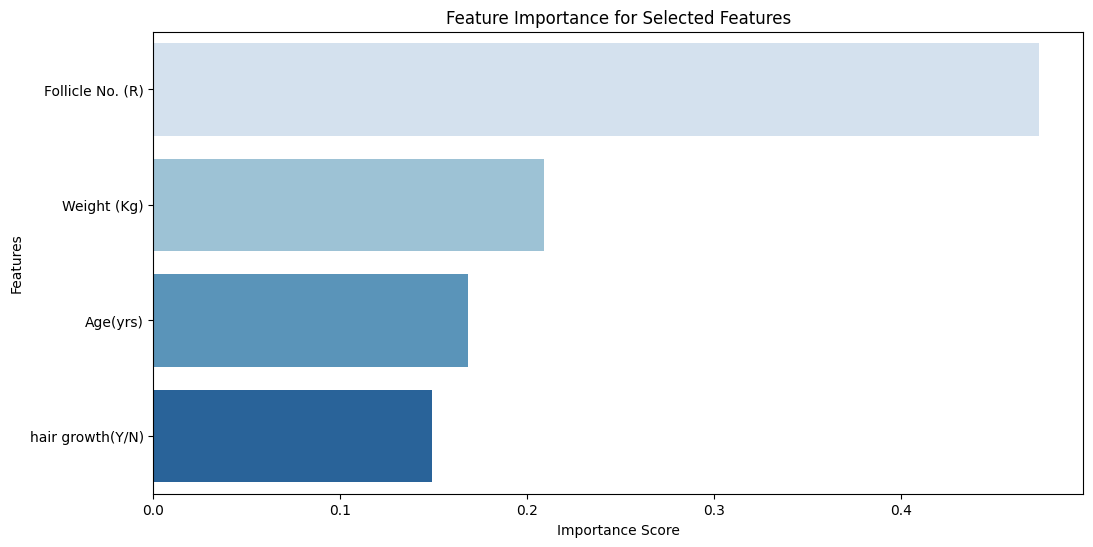

         Feature  Importance
Follicle No. (R)    0.473669
     Weight (Kg)    0.209073
        Age(yrs)    0.168394
hair growth(Y/N)    0.148864


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load your cleaned data
data = pd.read_csv('cleaned_data.csv')

# Define your target variable
target_variable = 'PCOS (Y/N)'

# Define your selected features (you can change these to any 4 features you prefer)
selected_features = [
    'Age(yrs)', 'Weight (Kg)', 'Follicle No. (R)', 'hair growth(Y/N)']

# Define your features and target variable
X = data[selected_features]  # Use selected features
y = data[target_variable]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot feature importance
importance = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': selected_features, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, hue='Feature', palette='Blues', legend=False)
plt.title('Feature Importance for Selected Features')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Display the feature importance DataFrame without index
print(feature_importance.to_string(index=False))


Multi Layer Perceptron (MLP)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7467 - loss: 0.5867 - val_accuracy: 0.8583 - val_loss: 0.3797
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8857 - loss: 0.3213 - val_accuracy: 0.8633 - val_loss: 0.3355
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8881 - loss: 0.3027 - val_accuracy: 0.8717 - val_loss: 0.3336
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8936 - loss: 0.2981 - val_accuracy: 0.8750 - val_loss: 0.3295
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8910 - loss: 0.2787 - val_accuracy: 0.8783 - val_loss: 0.3291
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8944 - loss: 0.2746 - val_accuracy: 0.8783 - val_loss: 0.3240
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9043 - loss: 0.2758 - val_accuracy: 0.8800 - val_loss: 0.3291
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8890 - loss: 0.2847 - val_accuracy: 0.8783 - val_loss: 0.3295
Epo

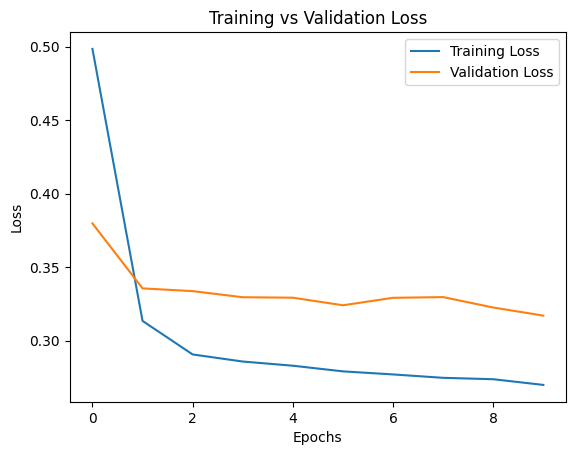

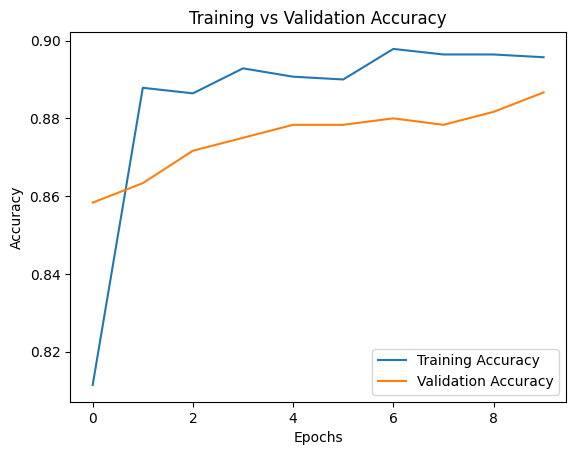

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 1: Define the features and target variable
X = data[['Age(yrs)', 'Weight (Kg)', 'Follicle No. (R)', 'hair growth(Y/N)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Build the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # Hidden layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Step 7: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Fit the model to the training data
history = model.fit(X_train, y_train, epochs=10, batch_size=20, validation_data=(X_test, y_test))

# Step 9: Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 10: Make predictions (convert probabilities to binary predictions)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Step 11: Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# After training, plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Similarly, plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Gaussian Naive Bayes (GNB)

In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Step 1: Define the features and target variable
X = data[['Age(yrs)', 'Weight (Kg)', 'Follicle No. (R)', 'hair growth(Y/N)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Perform RFE with Logistic Regression to select the top features
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X, y)

# Step 5: Select only the top features from RFE
X_selected = X[X.columns[fit.support_]]

# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Step 7: Create and train the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Step 8: Make predictions on the test set
y_pred = gnb.predict(X_test)

# Step 9: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# Extract the weighted average precision, recall, and F1-score
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1-Score: {f1_score:.2f}")


Accuracy: 0.86
Weighted Precision: 0.86
Weighted Recall: 0.86
Weighted F1-Score: 0.86


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=10 > n_features=4. There will be no feature selection and all features will be kept.
  warnings.warn(


Updated Code with Cross-Validation and Monitoring

In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Step 1: Define the features and target variable
X = data[['Age(yrs)', 'Weight (Kg)', 'Follicle No. (R)', 'hair growth(Y/N)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Perform RFE with Logistic Regression to select the top features
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X, y)

# Step 5: Select only the top features from RFE
X_selected = X[X.columns[fit.support_]]

# Step 6: Use StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store training and validation metrics
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1_scores = []
val_f1_scores = []

# Step 7: Cross-validation
gnb = GaussianNB()

for train_index, val_index in kf.split(X_selected, y):
    # Split the data into training and validation sets for each fold
    X_train, X_val = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model on the training set
    gnb.fit(X_train, y_train)

    # Make predictions on the training and validation sets
    y_train_pred = gnb.predict(X_train)
    y_val_pred = gnb.predict(X_val)

    # Step 8: Evaluate on both training and validation sets
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    val_report = classification_report(y_val, y_val_pred, output_dict=True)

    # Collect accuracy, precision, recall, and F1-score for training
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    train_precisions.append(train_report['weighted avg']['precision'])
    train_recalls.append(train_report['weighted avg']['recall'])
    train_f1_scores.append(train_report['weighted avg']['f1-score'])

    # Collect accuracy, precision, recall, and F1-score for validation
    val_accuracies.append(accuracy_score(y_val, y_val_pred))
    val_precisions.append(val_report['weighted avg']['precision'])
    val_recalls.append(val_report['weighted avg']['recall'])
    val_f1_scores.append(val_report['weighted avg']['f1-score'])

# Step 9: Report average results across folds
print(f"Average Training Accuracy: {np.mean(train_accuracies):.2f}")
print(f"Average Validation Accuracy: {np.mean(val_accuracies):.2f}")
print(f"Average Training Precision: {np.mean(train_precisions):.2f}")
print(f"Average Validation Precision: {np.mean(val_precisions):.2f}")
print(f"Average Training Recall: {np.mean(train_recalls):.2f}")
print(f"Average Validation Recall: {np.mean(val_recalls):.2f}")
print(f"Average Training F1-Score: {np.mean(train_f1_scores):.2f}")
print(f"Average Validation F1-Score: {np.mean(val_f1_scores):.2f}")


Average Training Accuracy: 0.86
Average Validation Accuracy: 0.86
Average Training Precision: 0.87
Average Validation Precision: 0.87
Average Training Recall: 0.86
Average Validation Recall: 0.86
Average Training F1-Score: 0.86
Average Validation F1-Score: 0.87


Plot to compare the performance metrics of GNB and  MLP

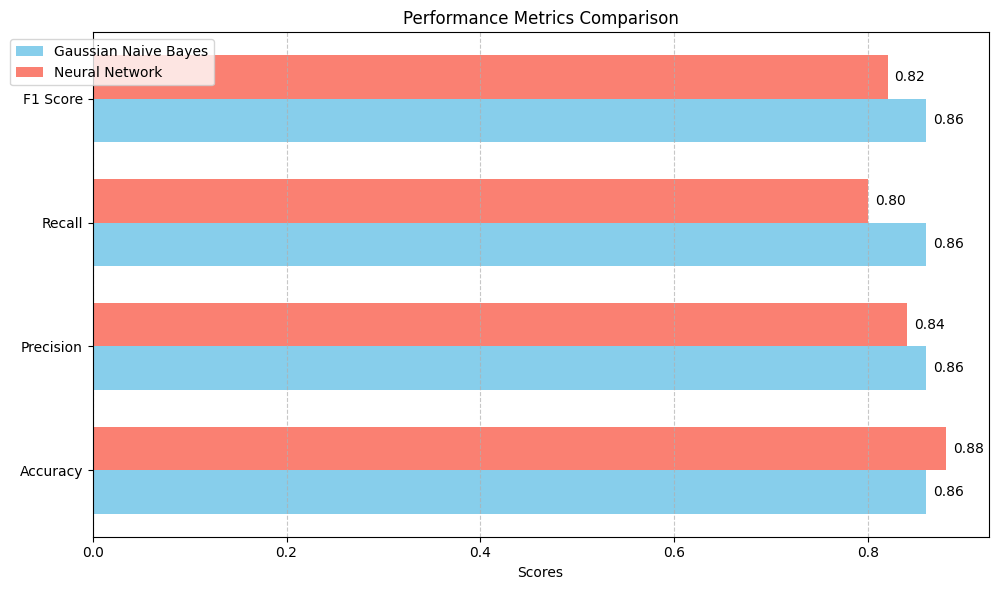

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics for Gaussian Naive Bayes
accuracy_gnb = 0.86
precision_gnb = 0.86
recall_gnb = 0.86
f1_gnb = 0.86

# Metrics for Multilayer Perceptron
accuracy_nn = 0.88
precision_nn = 0.84
recall_nn = 0.80
f1_nn = 0.82

# Performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
gnb_metrics = [accuracy_gnb, precision_gnb, recall_gnb, f1_gnb]
nn_metrics = [accuracy_nn, precision_nn, recall_nn, f1_nn]

# Create a horizontal bar graph to compare the two models
fig, ax = plt.subplots(figsize=(10, 6))

# Set bar width
bar_width = 0.35

# Define positions for the bars (both on the left)
y_pos = np.arange(len(metrics))

# Create horizontal bars for each model
bars1 = ax.barh(y_pos - bar_width / 2, gnb_metrics, bar_width, label='Gaussian Naive Bayes', color='skyblue')
bars2 = ax.barh(y_pos + bar_width / 2, nn_metrics, bar_width, label='Neural Network', color='salmon')

# Add labels and title
ax.set_xlabel('Scores')
ax.set_title('Performance Metrics Comparison')
ax.set_yticks(y_pos)  # Set y-ticks to the position of the metrics
ax.set_yticklabels(metrics)

# Adjust legend position to the left side
ax.legend(loc='upper left', bbox_to_anchor=(-0.1, 1))  # Change legend position to the left

# Add value labels on the right side of the bars
def add_value_labels(bars):
    for bar in bars:
        width = bar.get_width()
        ax.annotate(f'{width:.2f}',
                    xy=(width, bar.get_y() + bar.get_height()/2),
                    xytext=(5, 0),  # 5 points horizontal offset
                    textcoords="offset points",
                    va='center')

add_value_labels(bars1)
add_value_labels(bars2)

plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.tight_layout()  # Adjust layout to make room for the labels
plt.show()

Check for Overfitting


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Define your target variable
target_variable = 'PCOS (Y/N)'

# Define your selected features
selected_features = [
    'Age(yrs)', 'Weight (Kg)', 'Follicle No. (R)', 'hair growth(Y/N)'
]

# Define your features and target variable
X = data[selected_features]
y = data[target_variable]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation

# Print only the CV scores and mean CV score
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {np.mean(cv_scores)}")

# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1,
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

Cross-validation scores: [0.95   0.9625 0.97   0.9725 0.9675]
Mean CV score: 0.9645000000000001


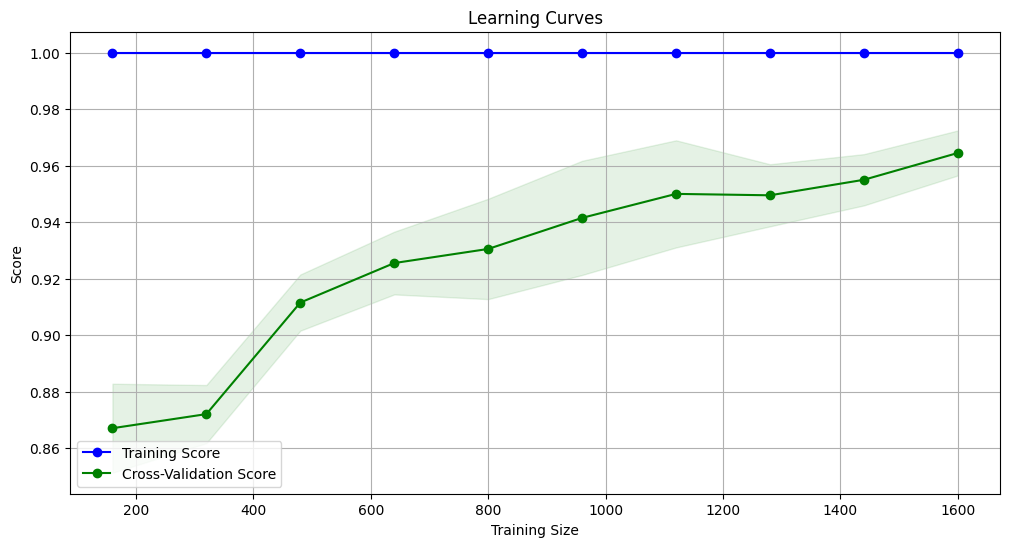

In [ ]:
# Plot Learning Curves
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-Validation Score')

# Plot the standard deviation as a shaded region
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color='blue')
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.1, color='green')

plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

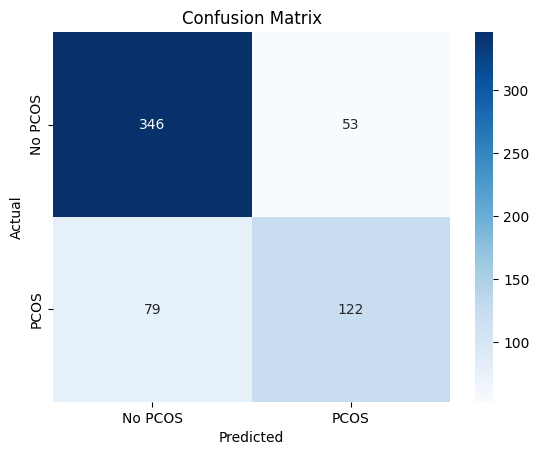

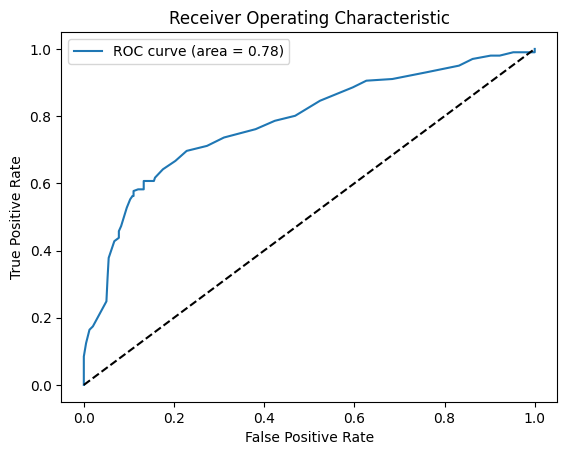

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No PCOS', 'PCOS'], yticklabels=['No PCOS', 'PCOS'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
y_probs = gnb.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')
plt.show()


Doing Feature Selection to identify the most important features

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your cleaned data
data = pd.read_csv('cleaned_data.csv')

# Assuming 'Target_Variable' is your target column
target_variable = 'PCOS (Y/N)'

# Generate the correlation matrix
correlation_matrix = data.corr()

# Identify features highly correlated with the target variable
correlation_with_target = correlation_matrix[target_variable].sort_values(ascending=False)

# Get the top 10 features correlated with the target variable
top_10_features = correlation_with_target.head(11)  # Include target variable itself
print("Top 10 features correlated with target variable:\n", top_10_features)


Top 10 features correlated with target variable:
 PCOS (Y/N)              1.000000
Follicle No. (R)        0.634140
Follicle No. (L)        0.599351
hair growth(Y/N)        0.482538
Skin darkening (Y/N)    0.466360
Weight gain(Y/N)        0.431333
Cycle(R/I)              0.398291
Fast food (Y/N)         0.384289
AMH(ng/mL)              0.289760
Pimples(Y/N)            0.278531
Weight (Kg)             0.221852
Name: PCOS (Y/N), dtype: float64


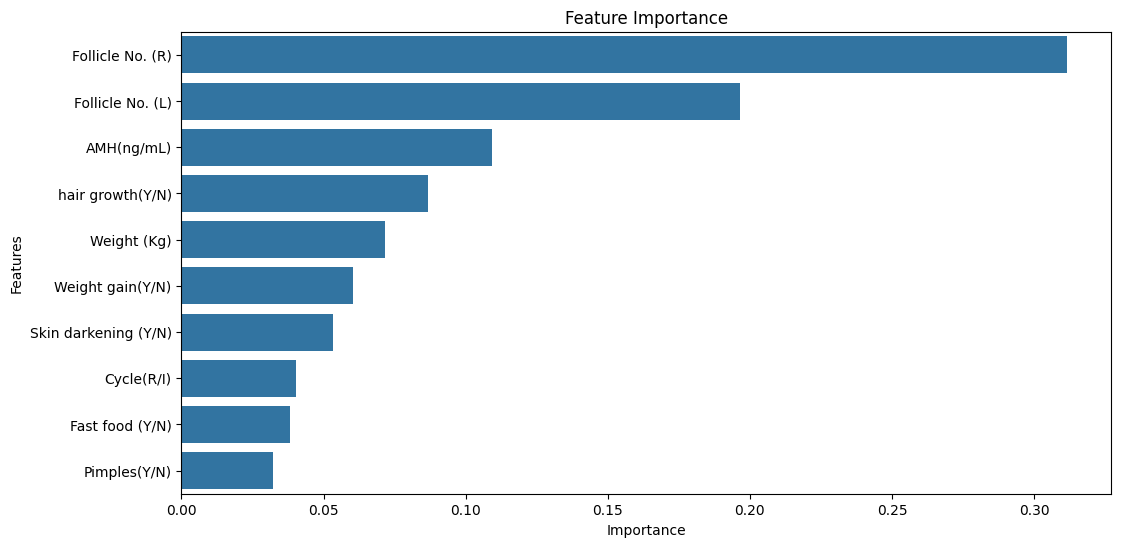

             Feature  Importance
    Follicle No. (R)    0.311588
    Follicle No. (L)    0.196536
          AMH(ng/mL)    0.109358
    hair growth(Y/N)    0.086768
         Weight (Kg)    0.071537
    Weight gain(Y/N)    0.060271
Skin darkening (Y/N)    0.053290
          Cycle(R/I)    0.040232
     Fast food (Y/N)    0.038171
        Pimples(Y/N)    0.032249


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load your cleaned data
data = pd.read_csv('cleaned_data.csv')

# Define your target variable
target_variable = 'PCOS (Y/N)'

# Define your features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]  # Top 10 features
y = data[target_variable]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
model = RandomForestClassifier(random_state=42)  # Use RandomForestRegressor if it's a regression problem
model.fit(X_train, y_train)

# Get feature importance
importance = model.feature_importances_

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance without index
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, errorbar=None)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Display the feature importance DataFrame
print(feature_importance.to_string(index=False))


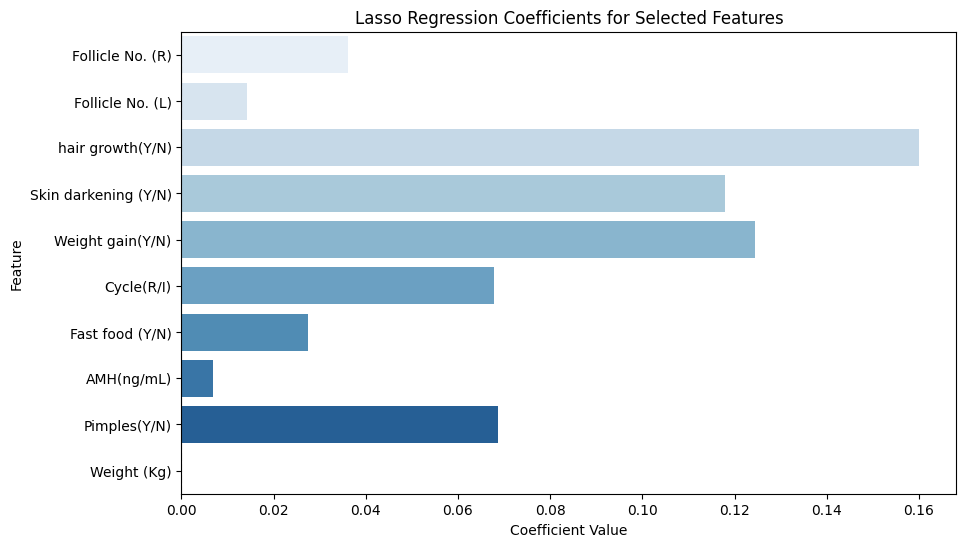

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Define your target variable
target_variable = 'PCOS (Y/N)'

# Define your features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data[target_variable]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Lasso model
lasso = LassoCV(cv=5)  # You can adjust the number of folds as needed
lasso.fit(X_train, y_train)

# Get the coefficients of the features
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})

# Filter features with non-zero coefficients
selected_features = coefficients[coefficients['Coefficient'] != 0]

# Plotting the coefficients using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=selected_features, hue='Feature', palette='Blues', legend=False)
plt.xlabel('Coefficient Value')
plt.title('Lasso Regression Coefficients for Selected Features')
plt.axvline(0, color='gray', linestyle='--')  # Add a vertical line at 0
plt.show()


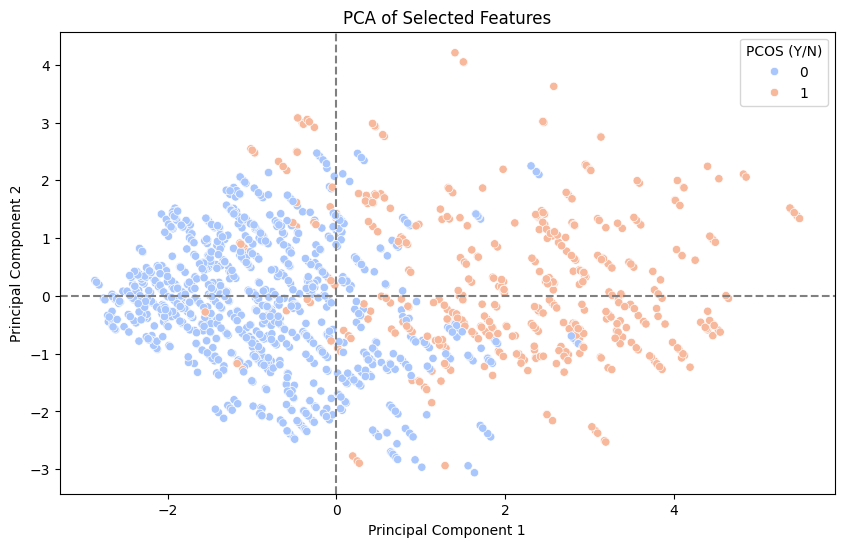

Explained Variance by Principal Components: [0.32676805 0.12704792]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define your target variable
target_variable = 'PCOS (Y/N)'

# Define your features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]  # Top 10 features
y = data[target_variable]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Create PCA object
pca = PCA(n_components=2)  # Change n_components to the number of components you want
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.reset_index(drop=True)

# Plot the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Target', data=pca_df, palette='coolwarm')
plt.title('PCA of Selected Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.legend(title='PCOS (Y/N)')
plt.show()

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance by Principal Components: {explained_variance}')


Multi Layer Perceptron (MLP)






Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6097 - loss: 0.6171 - val_accuracy: 0.8967 - val_loss: 0.2839
Epoch 2/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9231 - loss: 0.2444 - val_accuracy: 0.9050 - val_loss: 0.2465
Epoch 3/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9045 - loss: 0.2472 - val_accuracy: 0.9183 - val_loss: 0.2380
Epoch 4/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9260 - loss: 0.2055 - val_accuracy: 0.9150 - val_loss: 0.2296
Epoch 5/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9378 - loss: 0.1805 - val_accuracy: 0.9200 - val_loss: 0.2197
Epoch 6/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9311 - loss: 0.1771 - val_accuracy: 0.9217 - val_loss: 0.2171
Epoch 7/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9290 - loss: 0.1844 - val_accuracy: 0.9233 - val_loss: 0.2079
Epoch 8/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9509 - loss: 0.1551 - val_accuracy: 0.9267 - val_loss: 0.2

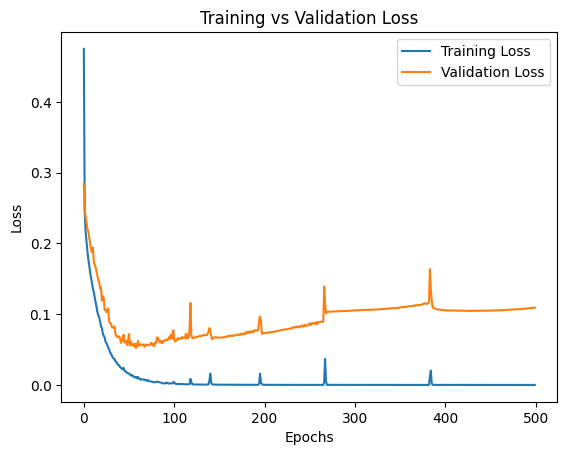

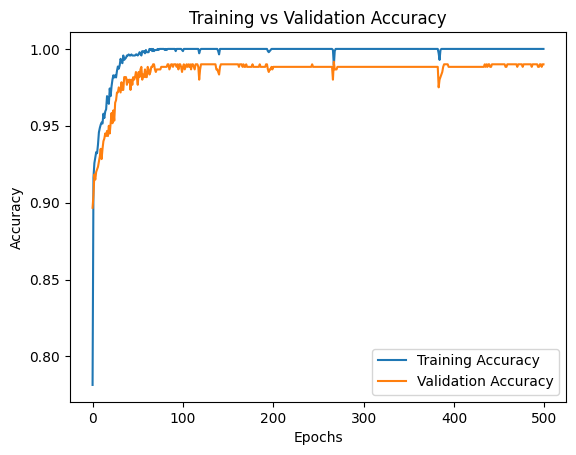

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score  # Import metrics for evaluation
import pandas as pd  # Import pandas for handling dataframes

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, columns=['hair growth(Y/N)', 'Skin darkening (Y/N)', 'Weight gain(Y/N)',
                               'Cycle(R/I)', 'Fast food (Y/N)', 'Pimples(Y/N)'], drop_first=True)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Align columns in training and testing sets
# Get missing columns in the training set
missing_cols_train = set(X_test.columns) - set(X_train.columns)
# Add a missing column in training set with default value equal to 0
for c in missing_cols_train:
    X_train[c] = 0
# Get missing columns in the testing set
missing_cols_test = set(X_train.columns) - set(X_test.columns)
# Add a missing column in testing set with default value equal to 0
for c in missing_cols_test:
    X_test[c] = 0

# Ensure the order of column in the test set is in the same order as in train set
X_test = X_test[X_train.columns]

# Step 6: Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 7: Build the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # Hidden layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Step 8: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 9: Fit the model to the training data
history = model.fit(X_train, y_train, epochs=500, batch_size=20, validation_data=(X_test, y_test))

# Step 10: Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 11: Make predictions
y_pred_prob = model.predict(X_test)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Step 12: Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# Step 13: Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 14: Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





Using SHAP (Interpretability Technique)

In [ ]:
pip install shap


In [ ]:
pip install scikit-learn shap lime pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 17.9 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f6831f4e2e8e995a273cae9535987e93769d71931016e38371f30183805b1951
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


  0%|          | 0/20 [00:00<?, ?it/s]

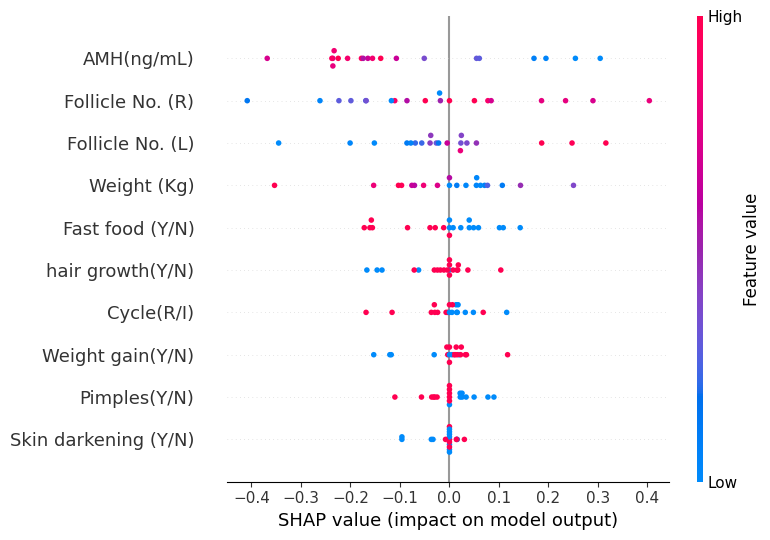

In [ ]:
import shap

# Create a SHAP KernelExplainer for your MLP model
explainer = shap.KernelExplainer(model.predict, X_train)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test, nsamples=100)

# Visualize SHAP summary plot for all features
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


Using LIME (Interpretability Technique)

In [ ]:
pip install lime

In [ ]:
import numpy as np
from lime.lime_tabular import LimeTabularExplainer

# Define a wrapper to output both probabilities (since LIME expects probabilities for both classes)
def predict_probabilities(X):
    preds = model.predict(X)  # Get predictions (probability of the positive class)
    return np.hstack((1 - preds, preds))  # Stack (1 - probability of class 1, probability of class 1)

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    X_train,  # Training data
    feature_names=X.columns,  # Feature names
    class_names=['No PCOS', 'PCOS'],  # Class names
    mode='classification'  # For classification problems
)

# Choose an instance to explain (e.g., the first test sample)
i = 0
exp = explainer.explain_instance(X_test[i], predict_probabilities, num_features=len(X.columns))  # Use all features

# Display the explanation in the notebook
exp.show_in_notebook(show_table=True, show_all=False)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Hyperparameter Tuning with KerasTuner

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


Hyperparameter Tuning with Keras Tuner

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import keras_tuner as kt

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, columns=['hair growth(Y/N)', 'Skin darkening (Y/N)', 'Weight gain(Y/N)',
                               'Cycle(R/I)', 'Fast food (Y/N)', 'Pimples(Y/N)'], drop_first=True)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Align columns in training and testing sets
missing_cols_train = set(X_test.columns) - set(X_train.columns)
for c in missing_cols_train:
    X_train[c] = 0
missing_cols_test = set(X_train.columns) - set(X_test.columns)
for c in missing_cols_test:
    X_test[c] = 0
X_test = X_test[X_train.columns]

# Step 6: Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 7: Define the model building function for KerasTuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32),
                    activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(units=hp.Int('units', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='LOG')),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 8: Initialize the KerasTuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='kt_dir',
                     project_name='hyperparameter_tuning')

# Step 9: Perform hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Step 10: Get the best hyperparameters and build the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test))

# Step 11: Evaluate the best model on the test data
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 12: Make predictions
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Step 13: Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Step 14: Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 15: Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'keras_tuner'

L2 Regularization









Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8178 - loss: 1.0944 - val_accuracy: 0.8850 - val_loss: 0.7365
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9014 - loss: 0.6696 - val_accuracy: 0.9033 - val_loss: 0.5567
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9172 - loss: 0.5012 - val_accuracy: 0.9050 - val_loss: 0.4577
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9171 - loss: 0.4077 - val_accuracy: 0.9100 - val_loss: 0.3976
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9093 - loss: 0.3816 - val_accuracy: 0.9117 - val_loss: 0.3633
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9228 - loss: 0.3325 - val_accuracy: 0.9117 - val_loss: 0.3413
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9220 - loss: 0.2963 - val_accuracy: 0.9167 - val_loss: 0.3169
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9351 - loss: 0.2954 - val_accuracy: 0.9067 - val_loss: 0.3

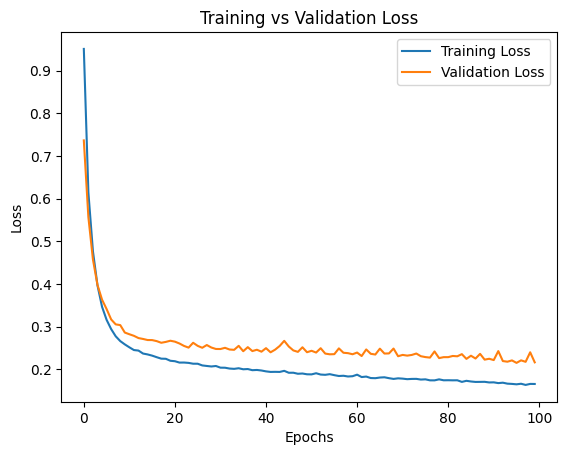

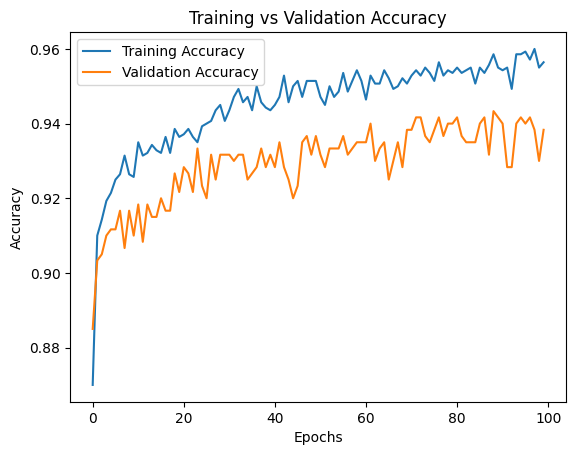

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
from tensorflow.keras.regularizers import l2  # Import L2 regularizer

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, columns=['hair growth(Y/N)', 'Skin darkening (Y/N)', 'Weight gain(Y/N)',
                               'Cycle(R/I)', 'Fast food (Y/N)', 'Pimples(Y/N)'], drop_first=True)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Align columns in training and testing sets
missing_cols_train = set(X_test.columns) - set(X_train.columns)
for c in missing_cols_train:
    X_train[c] = 0

missing_cols_test = set(X_train.columns) - set(X_test.columns)
for c in missing_cols_test:
    X_test[c] = 0
X_test = X_test[X_train.columns]

# Step 6: Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 7: Build the neural network model with L2 Regularization
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Another L2 regularization layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Step 8: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 9: Fit the model to the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test))

# Step 10: Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 11: Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Step 12: Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Step 13: Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 14: Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Hyperparameter Tuning followed by L2 regularization

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6536 - loss: 1.1633 - val_accuracy: 0.8950 - val_loss: 0.7669
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9080 - loss: 0.6965 - val_accuracy: 0.9000 - val_loss: 0.5914
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9120 - loss: 0.5350 - val_accuracy: 0.9117 - val_loss: 0.4893
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9280 - loss: 0.4279 - val_accuracy: 0.9100 - val_loss: 0.4192
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9160 - loss: 0.3764 - val_accuracy: 0.9150 - val_loss: 0.3731
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9316 - loss: 0.3298 - val_accuracy: 0.9117 - val_loss: 0.3445
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9287 - loss: 0.2992 - val_accuracy: 0.9150 - val_loss: 0.3212
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9327 - loss: 0.2679 - val_accuracy: 0.9150 -

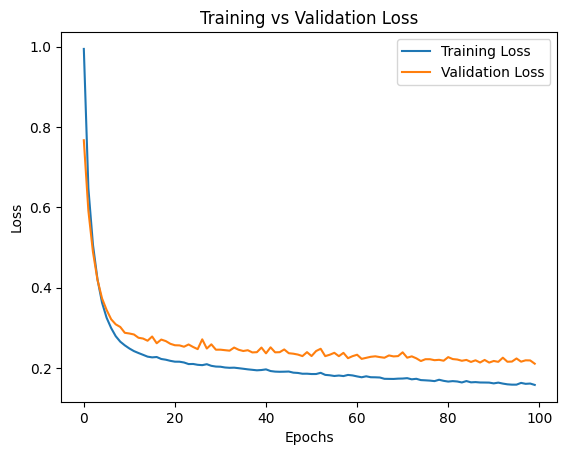

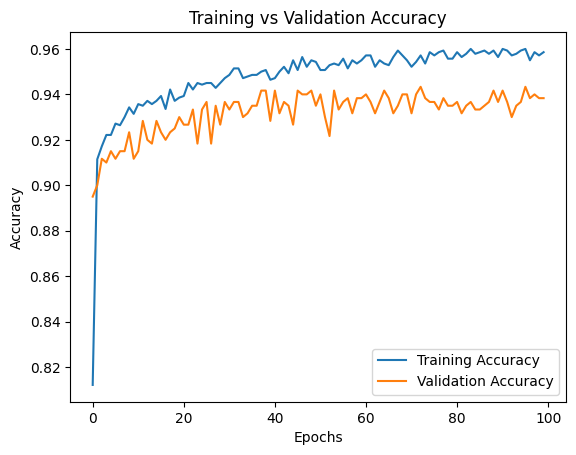

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2  # Import L2 regularization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, columns=['hair growth(Y/N)', 'Skin darkening (Y/N)', 'Weight gain(Y/N)',
                               'Cycle(R/I)', 'Fast food (Y/N)', 'Pimples(Y/N)'], drop_first=True)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Align columns in training and testing sets
missing_cols_train = set(X_test.columns) - set(X_train.columns)
for c in missing_cols_train:
    X_train[c] = 0

missing_cols_test = set(X_train.columns) - set(X_test.columns)
for c in missing_cols_test:
    X_test[c] = 0
X_test = X_test[X_train.columns]

# Step 6: Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 7: Build the neural network model with L2 regularization
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Step 8: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 9: Fit the model to the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test))

# Step 10: Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 11: Make predictions
y_pred_prob = model.predict(X_test)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Step 12: Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Step 13: Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 14: Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Updated Code with Dropout and Early Stopping (No signs of Overfitting)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6288 - loss: 1.1961 - val_accuracy: 0.9067 - val_loss: 0.7382
Epoch 2/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8659 - loss: 0.7559 - val_accuracy: 0.9079 - val_loss: 0.5542
Epoch 3/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8843 - loss: 0.5763 - val_accuracy: 0.9079 - val_loss: 0.4604
Epoch 4/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8842 - loss: 0.5168 - val_accuracy: 0.9115 - val_loss: 0.4002
Epoch 5/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9100 - loss: 0.4408 - val_accuracy: 0.9139 - val_loss: 0.3598
Epoch 6/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9035 - loss: 0.4027 - val_accuracy: 0.9139 - val_loss: 0.3299
Epoch 7/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9081 - loss: 0.3747 - val_accuracy: 0.9127 - val_loss: 0.3121
Epoch 8/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9137 - loss: 0.3373 - val_accuracy: 0.9127 - val_loss: 0.

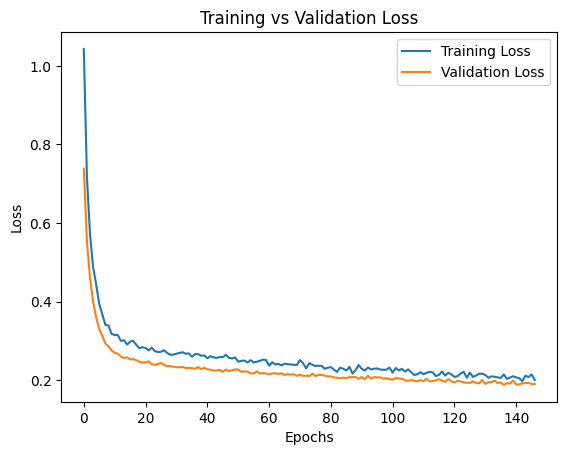

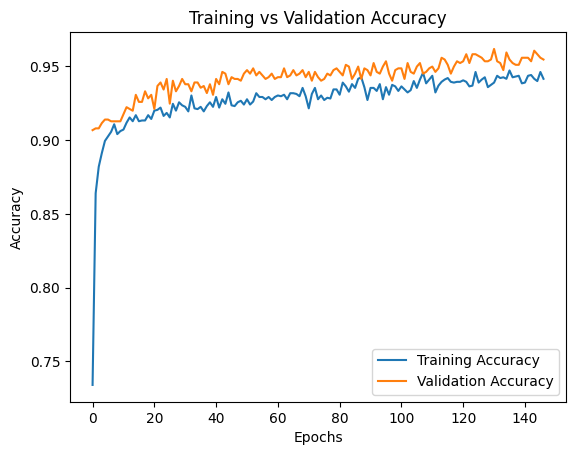

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout  # Import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, columns=['hair growth(Y/N)', 'Skin darkening (Y/N)', 'Weight gain(Y/N)',
                               'Cycle(R/I)', 'Fast food (Y/N)', 'Pimples(Y/N)'], drop_first=True)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Align columns in training and testing sets
missing_cols_train = set(X_test.columns) - set(X_train.columns)
for c in missing_cols_train:
    X_train[c] = 0

missing_cols_test = set(X_train.columns) - set(X_test.columns)
for c in missing_cols_test:
    X_test[c] = 0
X_test = X_test[X_train.columns]

# Step 6: Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 7: Build the neural network model with L2 regularization and Dropout
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(0.5),  # Dropout layer
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(0.5),  # Dropout layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Step 8: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 9: Implement EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 10: Fit the model to the training data
history = model.fit(X_train, y_train, epochs=500, batch_size=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Step 11: Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 12: Make predictions
y_pred_prob = model.predict(X_test)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Step 13: Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Step 14: Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 15: Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Taking user input with Data Imbalance

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6332 - loss: 1.1762 - val_accuracy: 0.9091 - val_loss: 0.7632
Epoch 2/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8587 - loss: 0.7654 - val_accuracy: 0.9055 - val_loss: 0.5571
Epoch 3/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8828 - loss: 0.5929 - val_accuracy: 0.9103 - val_loss: 0.4588
Epoch 4/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8933 - loss: 0.4915 - val_accuracy: 0.9127 - val_loss: 0.3995
Epoch 5/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8973 - loss: 0.4588 - val_accuracy: 0.9139 - val_loss: 0.3595
Epoch 6/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9054 - loss: 0.4090 - val_accuracy: 0.9127 - val_loss: 0.3320
Epoch 7/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9066 - loss: 0.3699 - val_accuracy: 0.9175 - val_loss: 0.3128
Epoch 8/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8991 - loss: 0.3601 - val_accuracy: 0.9163 - val_loss: 0.2

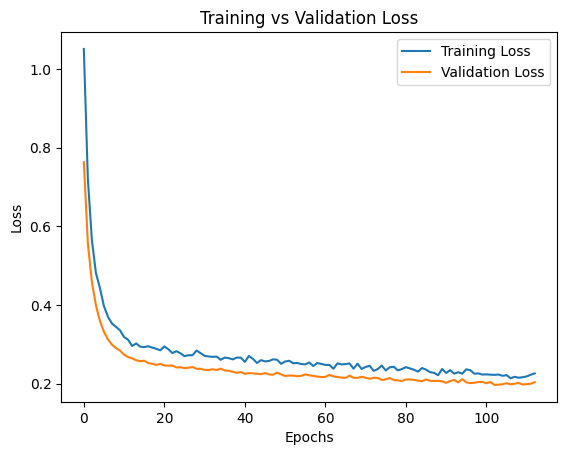

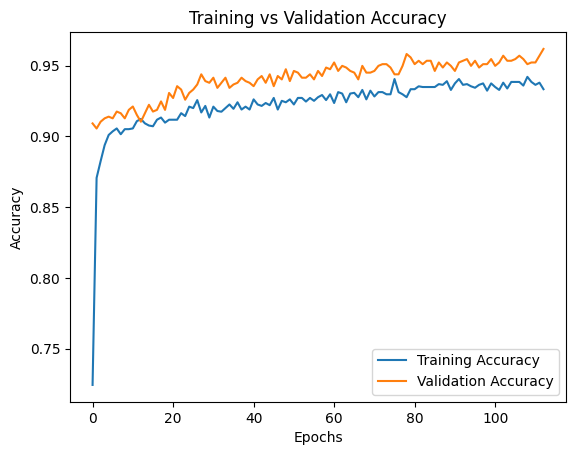

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# Assuming 'data' is preloaded as a DataFrame
# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, columns=['hair growth(Y/N)', 'Skin darkening (Y/N)', 'Weight gain(Y/N)',
                               'Cycle(R/I)', 'Fast food (Y/N)', 'Pimples(Y/N)'], drop_first=True)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Align columns in training and testing sets
missing_cols_train = set(X_test.columns) - set(X_train.columns)
for c in missing_cols_train:
    X_train[c] = 0

missing_cols_test = set(X_train.columns) - set(X_test.columns)
for c in missing_cols_test:
    X_test[c] = 0
X_test = X_test[X_train.columns]

# Step 6: Normalize the feature data and store column names
scaler = StandardScaler()
X_train_columns = X_train.columns  # Store the column names before scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 7: Build the neural network model with L2 regularization and Dropout
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Step 8: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 9: Implement EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 10: Fit the model to the training data
history = model.fit(X_train, y_train, epochs=500, batch_size=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Step 11: Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 12: Take user input for the ten features
def get_user_input():
    follicle_r = float(input("Enter the number of follicles in the right ovary: "))
    follicle_l = float(input("Enter the number of follicles in the left ovary: "))
    hair_growth = int(input("Hair growth (0 for No, 1 for Yes): "))
    skin_darkening = int(input("Skin darkening (0 for No, 1 for Yes): "))
    weight_gain = int(input("Weight gain (0 for No, 1 for Yes): "))

    # Take input as 4 or 2 and map it accordingly
    cycle_input = int(input("Cycle (4 for Regular, 2 for Irregular): "))
    cycle = 4 if cycle_input == 4 else 2  # Keep it as 4 or 2 (for one-hot encoding compatibility)

    fast_food = int(input("Fast food consumption (0 for No, 1 for Yes): "))
    amh = float(input("Enter the AMH level (ng/mL): "))
    pimples = int(input("Pimples (0 for No, 1 for Yes): "))
    weight_kg = float(input("Enter weight (Kg): "))

    # Create the input as a DataFrame
    user_data = pd.DataFrame([[follicle_r, follicle_l, hair_growth, skin_darkening, weight_gain, cycle, fast_food, amh, pimples, weight_kg]],
                        columns=['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)_1',
                                 'Skin darkening (Y/N)_1', 'Weight gain(Y/N)_1', 'Cycle(R/I)',
                                 'Fast food (Y/N)_1', 'AMH(ng/mL)', 'Pimples(Y/N)_1', 'Weight (Kg)'])

    # Perform one-hot encoding to match the training data structure
    user_data_encoded = pd.get_dummies(user_data, columns=['Cycle(R/I)'], drop_first=True)

    # Align columns with the stored column names from the training data
    for col in X_train_columns:
        if col not in user_data_encoded.columns:
            user_data_encoded[col] = 0

    # Ensure the order of columns matches
    user_data_encoded = user_data_encoded[X_train_columns]

    return user_data_encoded

# Get user input and scale it
user_input = get_user_input()
user_input_scaled = scaler.transform(user_input)

# Step 13: Make predictions on user input
user_pred_prob = model.predict(user_input_scaled)
user_pred = (user_pred_prob > 0.5).astype(int)

# Step 14: Display prediction result
print(f"Prediction (PCOS 1=Yes, 0=No): {user_pred[0][0]}")

# Step 15: Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 16: Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00


Removing Overfitting by the combination of regularization, dropout, early stopping and normalization

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6695 - loss: 1.1910 - val_accuracy: 0.8971 - val_loss: 0.7563
Epoch 2/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8543 - loss: 0.7762 - val_accuracy: 0.9127 - val_loss: 0.5754
Epoch 3/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8824 - loss: 0.6366 - val_accuracy: 0.9127 - val_loss: 0.4880
Epoch 4/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8927 - loss: 0.5515 - val_accuracy: 0.9127 - val_loss: 0.4252
Epoch 5/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8948 - loss: 0.4616 - val_accuracy: 0.9151 - val_loss: 0.3813
Epoch 6/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9070 - loss: 0.4272 - val_accuracy: 0.9103 - val_loss: 0.3518
Epoch 7/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9128 - loss: 0.3830 - val_accuracy: 0.9103 - val_loss: 0.3297
Epoch 8/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9063 - loss: 0.3674 - val_accuracy: 0.9127 - val_loss: 0.3

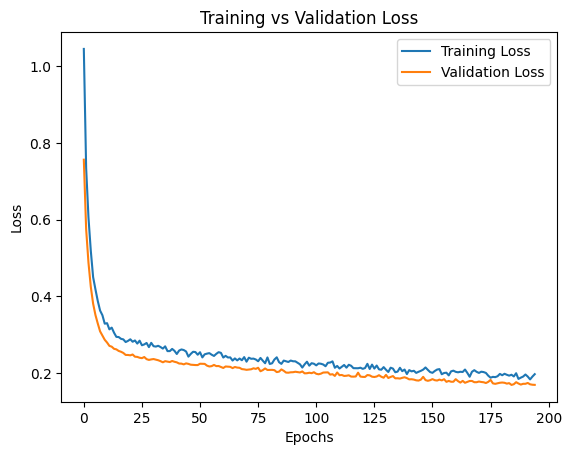

<function matplotlib.pyplot.legend(*args, **kwargs)>

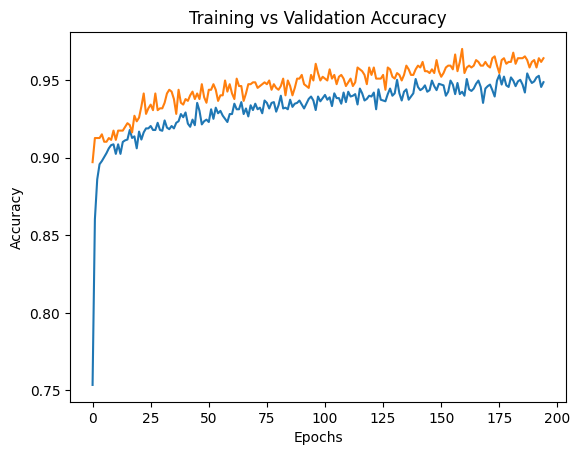

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample

def collect_and_clean_data(file_path):
    # Load data
    data = pd.read_csv(file_path)

    # Clean column names
    data.columns = data.columns.str.strip()  # Remove leading/trailing whitespace
    data.columns = data.columns.str.replace('\xa0', ' ')  # Replace non-breaking spaces

    # Clean data entries
    for col in data.columns:
        if data[col].dtype == 'object':  # Apply only to string columns
            data[col] = data[col].str.strip()  # Remove leading/trailing whitespace
            data[col] = data[col].str.replace('\xa0', ' ')  # Replace non-breaking spaces

    # Handle non-numeric values in numeric columns
    for col in data.columns:
        if data[col].dtype == 'object':
            try:
                # Attempt to convert to numeric
                data[col] = pd.to_numeric(data[col], errors='coerce')
            except ValueError:
                pass

        # Interpolate non-numeric (NaN) values
        if data[col].dtype in ['float64', 'int64']:
            data[col] = data[col].interpolate(method='linear', limit_direction='both')

    # Handle missing values (if any remain after interpolation)
    data = data.dropna()

    # Handle class imbalance
    target_variable = 'PCOS (Y/N)'  # Replace with your actual target variable name

    if target_variable in data.columns:
        # Separate majority and minority classes
        majority_class = data[data[target_variable] == 0]
        minority_class = data[data[target_variable] == 1]

        # Upsample minority class
        minority_upsampled = resample(minority_class,
                                      replace=True,     # Sample with replacement
                                      n_samples=len(majority_class),  # Match majority class
                                      random_state=42)  # Reproducible results

        # Combine majority class with upsampled minority class
        data = pd.concat([majority_class, minority_upsampled])

        # Shuffle the dataset
        data = data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Save cleaned data
    cleaned_dataset_path = 'cleaned_data.csv'
    data.to_csv(cleaned_dataset_path, index=False)

    return data

# Load and clean the data
file_path = 'PCOS_extended_dataset.csv'  # Replace with your actual file name
data = collect_and_clean_data(file_path)

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()
y = y.loc[X.index]

# Step 3: Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, columns=['hair growth(Y/N)', 'Skin darkening (Y/N)', 'Weight gain(Y/N)',
                               'Cycle(R/I)', 'Fast food (Y/N)', 'Pimples(Y/N)'], drop_first=True)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Align columns in training and testing sets
missing_cols_train = set(X_test.columns) - set(X_train.columns)
for c in missing_cols_train:
    X_train[c] = 0

missing_cols_test = set(X_train.columns) - set(X_test.columns)
for c in missing_cols_test:
    X_test[c] = 0
X_test = X_test[X_train.columns]

# Step 6: Normalize the feature data and store column names
scaler = StandardScaler()
X_train_columns = X_train.columns  # Store the column names before scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 7: Build the neural network model with L2 regularization and Dropout
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Step 8: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 9: Implement EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 10: Fit the model to the training data
history = model.fit(X_train, y_train, epochs=500, batch_size=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Step 11: Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 12: Take user input for the ten features
def get_user_input():
    while True:  # Loop until valid input is received
        try:
            follicle_r = float(input("Enter the number of follicles in the right ovary: "))
            follicle_l = float(input("Enter the number of follicles in the left ovary: "))
            hair_growth = int(input("Hair growth (0 for No, 1 for Yes): "))
            skin_darkening = int(input("Skin darkening (0 for No, 1 for Yes): "))
            weight_gain = int(input("Weight gain (0 for No, 1 for Yes): "))

            # Take input as 4 or 2 and map it accordingly
            cycle_input = int(input("Cycle (4 for Regular, 2 for Irregular): "))
            if cycle_input not in [2, 4]:
                raise ValueError("Cycle must be 4 (Regular) or 2 (Irregular)")

            fast_food = int(input("Fast food consumption (0 for No, 1 for Yes): "))
            amh = float(input("Enter the AMH level (ng/mL): "))
            pimples = int(input("Pimples (0 for No, 1 for Yes): "))
            weight_kg = float(input("Enter weight (Kg): "))

            # Create the input as a DataFrame
            user_data = pd.DataFrame([[follicle_r, follicle_l, hair_growth, skin_darkening, weight_gain, cycle_input, fast_food, amh, pimples, weight_kg]],
                                      columns=['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
                                               'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)', 'Pimples(Y/N)', 'Weight (Kg)'])

            # Perform one-hot encoding to match the training data structure
            user_data_encoded = pd.get_dummies(user_data, columns=['hair growth(Y/N)', 'Skin darkening (Y/N)', 'Weight gain(Y/N)',
                                                                   'Cycle(R/I)', 'Fast food (Y/N)', 'Pimples(Y/N)'], drop_first=True)

            # Align columns with the stored column names from the training data
            for col in X_train_columns:
                if col not in user_data_encoded.columns:
                    user_data_encoded[col] = 0

            # Ensure the order of columns matches
            user_data_encoded = user_data_encoded[X_train_columns]

            return user_data_encoded

        except ValueError as e:
            print(f"Invalid input: {e}. Please try again.")

# Get user input and scale it
user_input = get_user_input()
user_input_scaled = scaler.transform(user_input)

# Step 13: Make predictions on user input
user_pred_prob = model.predict(user_input_scaled)
user_pred = (user_pred_prob > 0.5).astype(int)

# Step 14: Display prediction result
print(f"Prediction (PCOS 1=Yes, 0=No): {user_pred[0][0]}")

# Step 15: Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 16: Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend


In [ ]:
model.save('model.h5')

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [ ]:
%%writefile hello_world.py
import streamlit as st

# Set the title of the app
st.title("Hello, World!")

# Display a simple message
st.write("Welcome to my first Streamlit app!")


Overwriting hello_world.py


In [ ]:
!streamlit run hello_world.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.32.202.210:8501

your url is: https://big-dancers-mate.loca.lt
  Stopping...
^C


In [ ]:
curl https://loca.lt/mytunnelpassword

SyntaxError: invalid syntax (<ipython-input-68-0091ffcafecb>, line 1)

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to oversample the minority class in the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model on the resampled dataset
model = LogisticRegression(random_state=42)
model.fit(X_resampled_scaled, y_resampled)

# Evaluate the model on the test data
y_pred = model.predict(X_test_scaled)
print("Logistic Regression Model Performance:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Store the original column names for later use
original_columns = X.columns.tolist()

def get_user_input():
    # Get user inputs for each feature
    follicle_no_r = float(input("Enter Follicle No. (Right): "))
    follicle_no_l = float(input("Enter Follicle No. (Left): "))
    hair_growth = input("Hair Growth (Y/N): ").strip().lower()
    skin_darkening = input("Skin Darkening (Y/N): ").strip().lower()
    weight_gain = input("Weight Gain (Y/N): ").strip().lower()
    cycle = input("Cycle (R/I): ").strip().lower()  # Regular or Irregular
    fast_food = input("Fast Food (Y/N): ").strip().lower()
    amh = float(input("Enter AMH (ng/mL): "))
    pimples = input("Pimples (Y/N): ").strip().lower()
    weight = float(input("Enter Weight (Kg): "))

    # Convert categorical inputs to numeric using one-hot encoding
    input_data = {
        'Follicle No. (R)': follicle_no_r,
        'Follicle No. (L)': follicle_no_l,
        'hair growth(Y/N)': 1 if hair_growth == 'y' else 0,
        'Skin darkening (Y/N)': 1 if skin_darkening == 'y' else 0,
        'Weight gain(Y/N)': 1 if weight_gain == 'y' else 0,
        'Cycle(R/I)': 1 if cycle == 'r' else 0,  # Assuming 'r' for Regular and 'i' for Irregular
        'Fast food (Y/N)': 1 if fast_food == 'y' else 0,
        'AMH(ng/mL)': amh,
        'Pimples(Y/N)': 1 if pimples == 'y' else 0,
        'Weight (Kg)': weight
    }

    return pd.DataFrame([input_data])

# Function to predict PCOS
def predict_pcos(model, scaler):
    # Get user input
    user_input = get_user_input()

    # Preprocess the input data
    user_input = pd.get_dummies(user_input, columns=['hair growth(Y/N)', 'Skin darkening (Y/N)',
                                                     'Weight gain(Y/N)', 'Cycle(R/I)',
                                                     'Fast food (Y/N)', 'Pimples(Y/N)'], drop_first=True)

    # Align columns with the training set using original columns
    for col in original_columns:
        if col not in user_input.columns:
            user_input[col] = 0  # Add missing columns with default value 0

    # Ensure the order of columns matches the training set
    user_input = user_input[original_columns]

    # Scale the input data
    user_input_scaled = scaler.transform(user_input)

    # Make a prediction
    prediction_prob = model.predict_proba(user_input_scaled)[:, 1]  # Get probability for class 1 (PCOS)

    # Lower the threshold to 0.3 instead of 0.5
    threshold = 0.3
    prediction = (prediction_prob >= threshold).astype(int)

    # Debugging output
    print("User input after preprocessing:", user_input)
    print("Prediction probabilities:", prediction_prob)

    # Output the prediction result
    if prediction[0] == 1:
        print("The model predicts: PCOS")
    else:
        print("The model predicts: No PCOS")

# Call the prediction function
predict_pcos(model, scaler)

# Feature Importance Analysis
coefficients = model.coef_[0]
feature_importance = pd.DataFrame(zip(original_columns, coefficients), columns=['Feature', 'Coefficient'])
print("Feature Importance from Logistic Regression:")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

# Try a more complex model: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled_scaled, y_resampled)

# Evaluate the Random Forest model on the test data
rf_y_pred = rf_model.predict(X_test_scaled)
print("Random Forest Model Performance:")
print(classification_report(y_test, rf_y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_y_pred))


Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       418
           1       0.82      0.92      0.87       182

    accuracy                           0.91       600
   macro avg       0.89      0.92      0.90       600
weighted avg       0.92      0.91      0.91       600

Confusion Matrix:
 [[380  38]
 [ 14 168]]


KeyboardInterrupt: Interrupted by user

Training a Random Forest Classifier to predict PCOS based on user-provided input

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Sample data loading (replace with your actual dataset)
# Assuming X (features) and y (target) are already defined

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to oversample the minority class in the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model on the resampled dataset
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled_scaled, y_resampled)

# Evaluate the model on the test data
y_pred = model.predict(X_test_scaled)
print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Store the original column names for later use
original_columns = X.columns.tolist()

def get_user_input():
    # Get user inputs for each feature
    follicle_no_r = float(input("Enter Follicle No. (Right): "))
    follicle_no_l = float(input("Enter Follicle No. (Left): "))
    hair_growth = input("Hair Growth (Y/N): ").strip().lower()
    skin_darkening = input("Skin Darkening (Y/N): ").strip().lower()
    weight_gain = input("Weight Gain (Y/N): ").strip().lower()
    cycle = input("Cycle (R/I): ").strip().lower()  # Regular or Irregular
    fast_food = input("Fast Food (Y/N): ").strip().lower()
    amh = float(input("Enter AMH (ng/mL): "))
    pimples = input("Pimples (Y/N): ").strip().lower()
    weight = float(input("Enter Weight (Kg): "))

    # Convert categorical inputs to numeric using one-hot encoding
    input_data = {
        'Follicle No. (R)': follicle_no_r,
        'Follicle No. (L)': follicle_no_l,
        'hair growth(Y/N)': 1 if hair_growth == 'y' else 0,
        'Skin darkening (Y/N)': 1 if skin_darkening == 'y' else 0,
        'Weight gain(Y/N)': 1 if weight_gain == 'y' else 0,
        'Cycle(R/I)': 1 if cycle == 'r' else 0,  # Assuming 'r' for Regular and 'i' for Irregular
        'Fast food (Y/N)': 1 if fast_food == 'y' else 0,
        'AMH(ng/mL)': amh,
        'Pimples(Y/N)': 1 if pimples == 'y' else 0,
        'Weight (Kg)': weight
    }

    return pd.DataFrame([input_data])

# Function to predict PCOS
def predict_pcos(model, scaler):
    # Get user input
    user_input = get_user_input()

    # Preprocess the input data
    user_input = pd.get_dummies(user_input, columns=['hair growth(Y/N)', 'Skin darkening (Y/N)',
                                                     'Weight gain(Y/N)', 'Cycle(R/I)',
                                                     'Fast food (Y/N)', 'Pimples(Y/N)'], drop_first=True)

    # Align columns with the training set using original columns
    for col in original_columns:
        if col not in user_input.columns:
            user_input[col] = 0  # Add missing columns with default value 0

    # Ensure the order of columns matches the training set
    user_input = user_input[original_columns]

    # Scale the input data
    user_input_scaled = scaler.transform(user_input)

    # Make a prediction
    prediction_prob = model.predict_proba(user_input_scaled)[:, 1]  # Get probability for class 1 (PCOS)

    # Set the threshold for prediction
    threshold = 0.1
    prediction = (prediction_prob >= threshold).astype(int)

    # Debugging output
    print("User input after preprocessing:", user_input)
    print("Prediction probabilities:", prediction_prob)

    # Output the prediction result
    if prediction[0] == 1:
        print("The model predicts: PCOS")
    else:
        print("The model predicts: No PCOS")

# Call the prediction function
predict_pcos(model, scaler)

# Feature Importance Analysis
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame(zip(original_columns, feature_importances), columns=['Feature', 'Importance'])
print("Feature Importance from Random Forest:")
print(feature_importance_df.sort_values(by='Importance', ascending=False))


Random Forest Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       418
           1       0.96      0.99      0.98       182

    accuracy                           0.99       600
   macro avg       0.98      0.99      0.98       600
weighted avg       0.99      0.99      0.99       600

Confusion Matrix:
 [[411   7]
 [  1 181]]
Enter Follicle No. (Right): 4
Enter Follicle No. (Left): 2
Hair Growth (Y/N): 1
Skin Darkening (Y/N): 0
Weight Gain (Y/N): 0
Cycle (R/I): 4
Fast Food (Y/N): 0
Enter AMH (ng/mL): 5.76
Pimples (Y/N): 1
Enter Weight (Kg): 69.97915
User input after preprocessing:    Follicle No. (R)  Follicle No. (L)  hair growth(Y/N)  Skin darkening (Y/N)  \
0               4.0               2.0                 0                     0   

   Weight gain(Y/N)  Cycle(R/I)  Fast food (Y/N)  AMH(ng/mL)  Pimples(Y/N)  \
0                 0           0                0        5.76             0   

   Weight (Kg)  
0

In [ ]:
model.save('model.h5')

In [ ]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Updated above with Hyperparameter Tuning

Trial 10 Complete [00h 00m 41s]
val_accuracy: 0.9964285492897034

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 03m 34s
Epoch 1/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8583 - loss: 0.4195 - val_accuracy: 0.9100 - val_loss: 0.3068
Epoch 2/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9129 - loss: 0.2587 - val_accuracy: 0.9250 - val_loss: 0.2550
Epoch 3/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9381 - loss: 0.2206 - val_accuracy: 0.9233 - val_loss: 0.2468
Epoch 4/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9443 - loss: 0.1841 - val_accuracy: 0.9283 - val_loss: 0.2291
Epoch 5/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9506 - loss: 0.1702 - val_accuracy: 0.9350 - val_loss: 0.2104
Epoch 6/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9459 - loss: 0.1697 - val_accuracy: 0.9283 - val_loss: 0.2152
Epoch 7/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9463 - loss: 0.1746 - val_accuracy: 0.9450 -

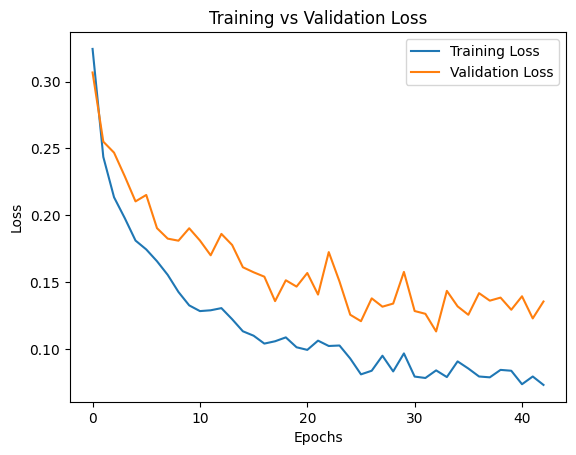

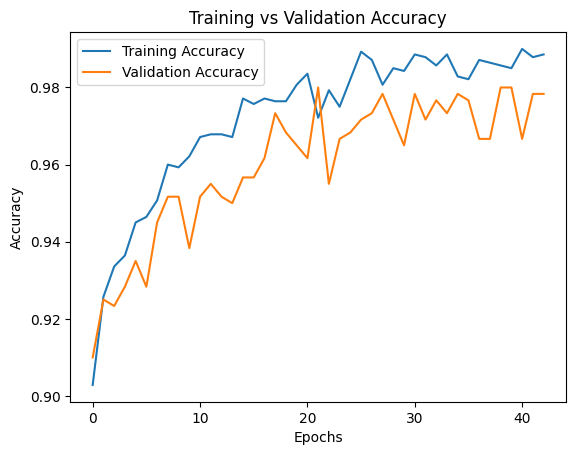

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import keras_tuner as kt  # Import Keras Tuner

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, columns=['hair growth(Y/N)', 'Skin darkening (Y/N)', 'Weight gain(Y/N)',
                               'Cycle(R/I)', 'Fast food (Y/N)', 'Pimples(Y/N)'], drop_first=True)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Align columns in training and testing sets
missing_cols_train = set(X_test.columns) - set(X_train.columns)
for c in missing_cols_train:
    X_train[c] = 0

missing_cols_test = set(X_train.columns) - set(X_test.columns)
for c in missing_cols_test:
    X_test[c] = 0
X_test = X_test[X_train.columns]

# Step 6: Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 7: Define the model-building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32),
                    activation='relu', kernel_regularizer=l2(hp.Float('l2_reg', 1e-5, 1e-2, sampling='LOG'))))
    model.add(Dropout(rate=hp.Float('dropout1', 0.1, 0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=64, step=16),
                    activation='relu', kernel_regularizer=l2(hp.Float('l2_reg', 1e-5, 1e-2, sampling='LOG'))))
    model.add(Dropout(rate=hp.Float('dropout2', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameter for learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 8: Set up the Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='pcos_prediction_tuning'
)

# Step 9: Run the tuner
tuner.search(X_train, y_train, epochs=50, batch_size=20, validation_split=0.2)

# Step 10: Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Step 11: Build the best model
best_model = tuner.hypermodel.build(best_hyperparameters)

# Step 12: Implement EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 13: Fit the best model to the training data
history = best_model.fit(X_train, y_train, epochs=500, batch_size=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Step 14: Evaluate the model on the test data
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 15: Make predictions
y_pred_prob = best_model.predict(X_test)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Step 16: Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Step 17: Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 18: Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Gaussian Naive Bayes (GNB)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Normalize the feature data (optional)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Build the Gaussian Naive Bayes model with var_smoothing hyperparameter
gnb = GaussianNB(var_smoothing=1e-9)

# Step 7: Train the model on the training data
gnb.fit(X_train, y_train)

# Step 8: Make predictions on the test data
y_pred = gnb.predict(X_test)

# Step 9: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 10: Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Test Accuracy: 0.89
Precision: 0.84
Recall: 0.84
F1 Score: 0.84


Updated Code with Cross-Validation and Monitoring

In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Step 1: Define the features and target variable
X = data[['Age(yrs)', 'Weight (Kg)', 'Follicle No. (R)', 'hair growth(Y/N)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Perform RFE with Logistic Regression to select the top features
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=2)  # Change this to select desired number of features
fit = rfe.fit(X, y)

# Step 5: Select only the top features from RFE
X_selected = X[X.columns[fit.support_]]

# Step 6: Use StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store training and validation metrics
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1_scores = []
val_f1_scores = []

# Step 7: Cross-validation
gnb = GaussianNB()

for train_index, val_index in kf.split(X_selected, y):
    # Split the data into training and validation sets for each fold
    X_train, X_val = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model on the training set
    gnb.fit(X_train, y_train)

    # Make predictions on the training and validation sets
    y_train_pred = gnb.predict(X_train)
    y_val_pred = gnb.predict(X_val)

    # Step 8: Evaluate on both training and validation sets
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    val_report = classification_report(y_val, y_val_pred, output_dict=True)

    # Collect accuracy, precision, recall, and F1-score for training
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    train_precisions.append(train_report['weighted avg']['precision'])
    train_recalls.append(train_report['weighted avg']['recall'])
    train_f1_scores.append(train_report['weighted avg']['f1-score'])

    # Collect accuracy, precision, recall, and F1-score for validation
    val_accuracies.append(accuracy_score(y_val, y_val_pred))
    val_precisions.append(val_report['weighted avg']['precision'])
    val_recalls.append(val_report['weighted avg']['recall'])
    val_f1_scores.append(val_report['weighted avg']['f1-score'])

# Step 9: Report average results across folds
print(f"Average Training Accuracy: {np.mean(train_accuracies):.2f}")
print(f"Average Validation Accuracy: {np.mean(val_accuracies):.2f}")
print(f"Average Training Precision: {np.mean(train_precisions):.2f}")
print(f"Average Validation Precision: {np.mean(val_precisions):.2f}")
print(f"Average Training Recall: {np.mean(train_recalls):.2f}")
print(f"Average Validation Recall: {np.mean(val_recalls):.2f}")
print(f"Average Training F1-Score: {np.mean(train_f1_scores):.2f}")
print(f"Average Validation F1-Score: {np.mean(val_f1_scores):.2f}")


Average Training Accuracy: 0.79
Average Validation Accuracy: 0.78
Average Training Precision: 0.78
Average Validation Precision: 0.78
Average Training Recall: 0.79
Average Validation Recall: 0.78
Average Training F1-Score: 0.78
Average Validation F1-Score: 0.78


Updated Code with Hyperparameter Tuning

In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import numpy as np

# Step 1: Define the features and target variable
X = data[['Age(yrs)', 'Weight (Kg)', 'Follicle No. (R)', 'hair growth(Y/N)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Perform RFE with Logistic Regression to select the top features
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X, y)

# Step 5: Select only the top features from RFE
X_selected = X[X.columns[fit.support_]]

# Step 6: Use StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 7: Set up hyperparameter grid for Gaussian Naive Bayes
param_grid = {'var_smoothing': np.logspace(0, -9, num=10)}  # 10 values from 1 to 1e-9

# Step 8: Initialize Gaussian Naive Bayes
gnb = GaussianNB()

# Step 9: Set up GridSearchCV
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=kf, scoring='accuracy')

# Step 10: Fit GridSearchCV
grid_search.fit(X_selected, y)

# Step 11: Get best hyperparameters
best_var_smoothing = grid_search.best_params_['var_smoothing']
print(f"Best var_smoothing: {best_var_smoothing}")

# Step 12: Train the model with best hyperparameters
gnb_best = GaussianNB(var_smoothing=best_var_smoothing)

# Step 13: Cross-validation metrics arrays
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1_scores = []
val_f1_scores = []

# Step 14: Cross-validation
for train_index, val_index in kf.split(X_selected, y):
    # Split the data into training and validation sets for each fold
    X_train, X_val = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model on the training set
    gnb_best.fit(X_train, y_train)

    # Make predictions on the training and validation sets
    y_train_pred = gnb_best.predict(X_train)
    y_val_pred = gnb_best.predict(X_val)

    # Step 15: Evaluate on both training and validation sets
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    val_report = classification_report(y_val, y_val_pred, output_dict=True)

    # Collect accuracy, precision, recall, and F1-score for training
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    train_precisions.append(train_report['weighted avg']['precision'])
    train_recalls.append(train_report['weighted avg']['recall'])
    train_f1_scores.append(train_report['weighted avg']['f1-score'])

    # Collect accuracy, precision, recall, and F1-score for validation
    val_accuracies.append(accuracy_score(y_val, y_val_pred))
    val_precisions.append(val_report['weighted avg']['precision'])
    val_recalls.append(val_report['weighted avg']['recall'])
    val_f1_scores.append(val_report['weighted avg']['f1-score'])

# Step 16: Report average results across folds
print(f"Average Training Accuracy: {np.mean(train_accuracies):.2f}")
print(f"Average Validation Accuracy: {np.mean(val_accuracies):.2f}")
print(f"Average Training Precision: {np.mean(train_precisions):.2f}")
print(f"Average Validation Precision: {np.mean(val_precisions):.2f}")
print(f"Average Training Recall: {np.mean(train_recalls):.2f}")
print(f"Average Validation Recall: {np.mean(val_recalls):.2f}")
print(f"Average Training F1-Score: {np.mean(train_f1_scores):.2f}")
print(f"Average Validation F1-Score: {np.mean(val_f1_scores):.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=10 > n_features=4. There will be no feature selection and all features will be kept.
  warnings.warn(


Best var_smoothing: 0.001
Average Training Accuracy: 0.88
Average Validation Accuracy: 0.88
Average Training Precision: 0.87
Average Validation Precision: 0.87
Average Training Recall: 0.88
Average Validation Recall: 0.88
Average Training F1-Score: 0.87
Average Validation F1-Score: 0.87


Check for Overfitting

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()

# Step 3: Also drop the corresponding rows in the target variable to keep the alignment
y = y.loc[X.index]

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Normalize the feature data (optional)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Build the Gaussian Naive Bayes model with var_smoothing hyperparameter
gnb = GaussianNB(var_smoothing=1e-9)

# Step 7: Train the model on the training data
gnb.fit(X_train, y_train)

# Step 8: Make predictions on the training data
y_train_pred = gnb.predict(X_train)

# Step 9: Make predictions on the test data
y_test_pred = gnb.predict(X_test)

# Step 10: Evaluate the model's performance on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Step 11: Evaluate the model's performance on test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Step 12: Print results
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Training Precision: {train_precision:.2f}")
print(f"Training Recall: {train_recall:.2f}")
print(f"Training F1 Score: {train_f1:.2f}")

print(f"\nTest Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")


Training Accuracy: 0.91
Training Precision: 0.83
Training Recall: 0.86
Training F1 Score: 0.84

Test Accuracy: 0.89
Test Precision: 0.84
Test Recall: 0.84
Test F1 Score: 0.84


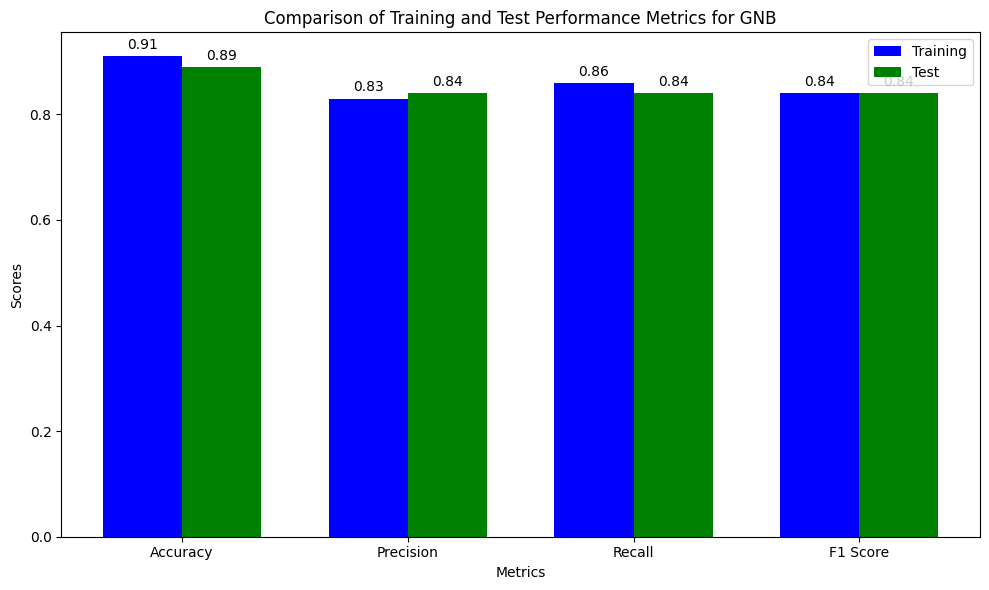

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
training_scores = [0.91, 0.83, 0.86, 0.84]  # Training metrics
test_scores = [0.89, 0.84, 0.84, 0.84]      # Test metrics

# Set the x locations for the bars
x = np.arange(len(metrics))

# Set width of bar
width = 0.35

# Create the bar plots
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, training_scores, width, label='Training', color='b')
bars2 = ax.bar(x + width/2, test_scores, width, label='Test', color='g')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Training and Test Performance Metrics for GNB')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value annotations on top of the bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


Bagging with Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Step 1: Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 2: Cross-validation metrics arrays for Random Forest
rf_train_accuracies = []
rf_val_accuracies = []
rf_train_precisions = []
rf_val_precisions = []
rf_train_recalls = []
rf_val_recalls = []
rf_train_f1_scores = []
rf_val_f1_scores = []

# Step 3: Cross-validation for Random Forest
for train_index, val_index in kf.split(X_selected, y):
    # Split the data into training and validation sets for each fold
    X_train, X_val = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model on the training set
    rf_model.fit(X_train, y_train)

    # Make predictions on the training and validation sets
    y_train_pred = rf_model.predict(X_train)
    y_val_pred = rf_model.predict(X_val)

    # Step 4: Evaluate on both training and validation sets
    rf_train_report = classification_report(y_train, y_train_pred, output_dict=True)
    rf_val_report = classification_report(y_val, y_val_pred, output_dict=True)

    # Collect accuracy, precision, recall, and F1-score for training
    rf_train_accuracies.append(accuracy_score(y_train, y_train_pred))
    rf_train_precisions.append(rf_train_report['weighted avg']['precision'])
    rf_train_recalls.append(rf_train_report['weighted avg']['recall'])
    rf_train_f1_scores.append(rf_train_report['weighted avg']['f1-score'])

    # Collect accuracy, precision, recall, and F1-score for validation
    rf_val_accuracies.append(accuracy_score(y_val, y_val_pred))
    rf_val_precisions.append(rf_val_report['weighted avg']['precision'])
    rf_val_recalls.append(rf_val_report['weighted avg']['recall'])
    rf_val_f1_scores.append(rf_val_report['weighted avg']['f1-score'])

# Step 5: Report average results across folds for Random Forest
print(f"Average Training Accuracy: {np.mean(rf_train_accuracies):.2f}")
print(f"Average Validation Accuracy: {np.mean(rf_val_accuracies):.2f}")
print(f"Average Training Precision: {np.mean(rf_train_precisions):.2f}")
print(f"Average Validation Precision: {np.mean(rf_val_precisions):.2f}")
print(f"Average Training Recall: {np.mean(rf_train_recalls):.2f}")
print(f"Average Validation Recall: {np.mean(rf_val_recalls):.2f}")
print(f"Average Training F1-Score: {np.mean(rf_train_f1_scores):.2f}")
print(f"Average Validation F1-Score: {np.mean(rf_val_f1_scores):.2f}")


Average Training Accuracy: 0.80
Average Validation Accuracy: 0.79
Average Training Precision: 0.79
Average Validation Precision: 0.79
Average Training Recall: 0.80
Average Validation Recall: 0.79
Average Training F1-Score: 0.79
Average Validation F1-Score: 0.79


Boosting with AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Step 1: Initialize the AdaBoost Classifier
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

# Step 2: Cross-validation metrics arrays for AdaBoost
ada_train_accuracies = []
ada_val_accuracies = []
ada_train_precisions = []
ada_val_precisions = []
ada_train_recalls = []
ada_val_recalls = []
ada_train_f1_scores = []
ada_val_f1_scores = []

# Step 3: Cross-validation for AdaBoost
for train_index, val_index in kf.split(X_selected, y):
    # Split the data into training and validation sets for each fold
    X_train, X_val = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model on the training set
    ada_model.fit(X_train, y_train)

    # Make predictions on the training and validation sets
    y_train_pred = ada_model.predict(X_train)
    y_val_pred = ada_model.predict(X_val)

    # Step 4: Evaluate on both training and validation sets
    ada_train_report = classification_report(y_train, y_train_pred, output_dict=True)
    ada_val_report = classification_report(y_val, y_val_pred, output_dict=True)

    # Collect accuracy, precision, recall, and F1-score for training
    ada_train_accuracies.append(accuracy_score(y_train, y_train_pred))
    ada_train_precisions.append(ada_train_report['weighted avg']['precision'])
    ada_train_recalls.append(ada_train_report['weighted avg']['recall'])
    ada_train_f1_scores.append(ada_train_report['weighted avg']['f1-score'])

    # Collect accuracy, precision, recall, and F1-score for validation
    ada_val_accuracies.append(accuracy_score(y_val, y_val_pred))
    ada_val_precisions.append(ada_val_report['weighted avg']['precision'])
    ada_val_recalls.append(ada_val_report['weighted avg']['recall'])
    ada_val_f1_scores.append(ada_val_report['weighted avg']['f1-score'])

# Step 5: Report average results across folds for AdaBoost
print(f"Average Training Accuracy: {np.mean(ada_train_accuracies):.2f}")
print(f"Average Validation Accuracy: {np.mean(ada_val_accuracies):.2f}")
print(f"Average Training Precision: {np.mean(ada_train_precisions):.2f}")
print(f"Average Validation Precision: {np.mean(ada_val_precisions):.2f}")
print(f"Average Training Recall: {np.mean(ada_train_recalls):.2f}")
print(f"Average Validation Recall: {np.mean(ada_val_recalls):.2f}")
print(f"Average Training F1-Score: {np.mean(ada_train_f1_scores):.2f}")
print(f"Average Validation F1-Score: {np.mean(ada_val_f1_scores):.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Average Training Accuracy: 0.79
Average Validation Accuracy: 0.79
Average Training Precision: 0.79
Average Validation Precision: 0.79
Average Training Recall: 0.79
Average Validation Recall: 0.79
Average Training F1-Score: 0.79
Average Validation F1-Score: 0.79


Feature Importance

Average Validation Accuracy: 0.96

Feature Importances:
            Feature  Importance
2  Follicle No. (R)    0.476325
1       Weight (Kg)    0.217106
0          Age(yrs)    0.163764
3  hair growth(Y/N)    0.142805


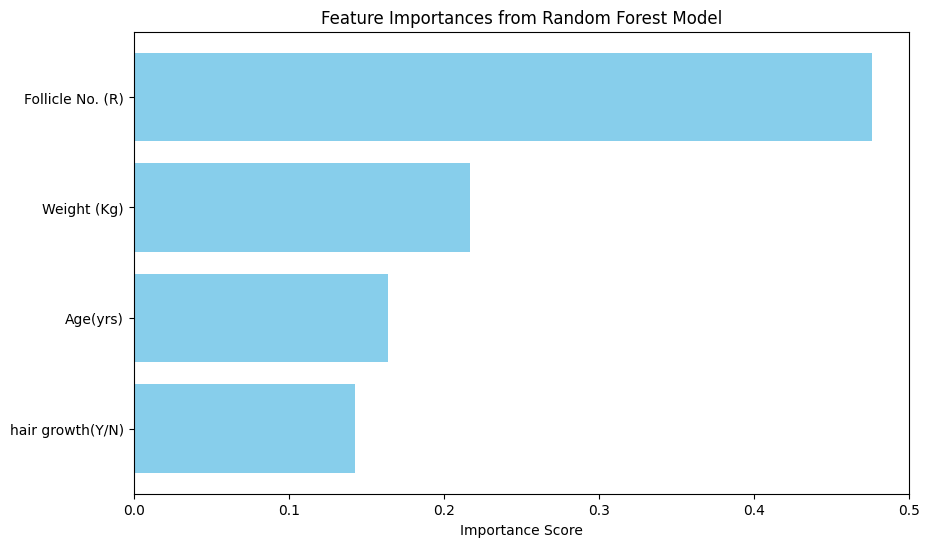

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the features and target variable
X = data[['Age(yrs)', 'Weight (Kg)', 'Follicle No. (R)', 'hair growth(Y/N)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()
y = y.loc[X.index]

# Step 3: Use StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store training and validation metrics
train_accuracies = []
val_accuracies = []

# Step 4: Cross-validation with Random Forest
rf = RandomForestClassifier(random_state=42)

for train_index, val_index in kf.split(X, y):
    # Split the data into training and validation sets for each fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model on the training set
    rf.fit(X_train, y_train)

    # Make predictions on the validation set
    y_val_pred = rf.predict(X_val)

    # Evaluate on validation set
    val_accuracies.append(accuracy_score(y_val, y_val_pred))

# Step 5: Report average results across folds
print(f"Average Validation Accuracy: {np.mean(val_accuracies):.2f}")

# Step 6: Feature Importance Analysis
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("\nFeature Importances:")
print(feature_importance_df)

# Step 7: Visualize Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


Plot to compare the performance metrics of GNB and MLP

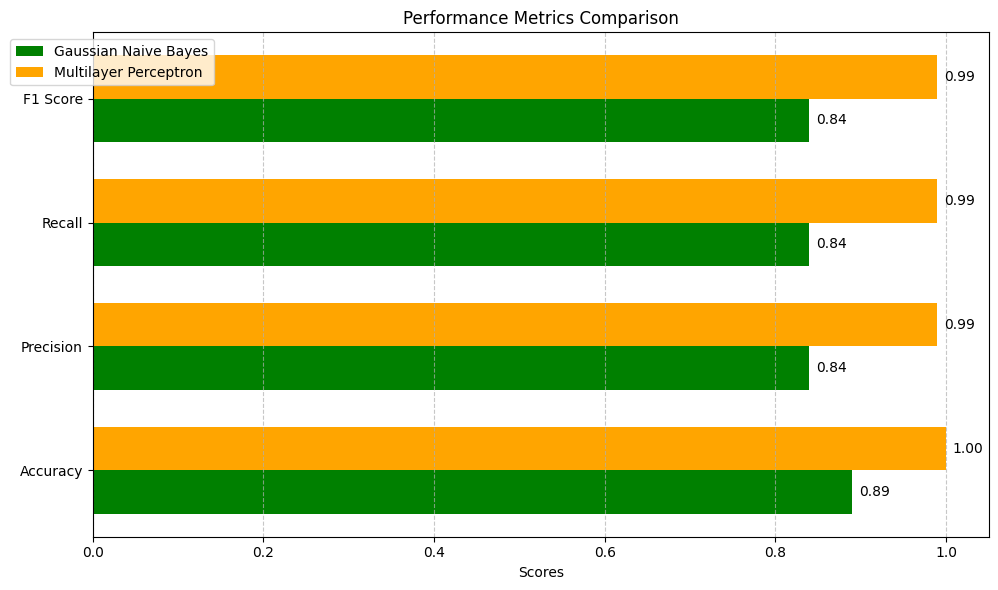

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics for Gaussian Naive Bayes
accuracy_gnb = 0.89
precision_gnb = 0.84
recall_gnb = 0.84
f1_gnb = 0.84

# Metrics for Multilayer Perceptron
accuracy_nn = 1.00
precision_nn = 0.99
recall_nn = 0.99
f1_nn = 0.99

# Performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
gnb_metrics = [accuracy_gnb, precision_gnb, recall_gnb, f1_gnb]
nn_metrics = [accuracy_nn, precision_nn, recall_nn, f1_nn]

# Create a horizontal bar graph to compare the two models
fig, ax = plt.subplots(figsize=(10, 6))

# Set bar width
bar_width = 0.35

# Define positions for the bars (both on the left)
y_pos = np.arange(len(metrics))

# Create horizontal bars for each model
bars1 = ax.barh(y_pos - bar_width / 2, gnb_metrics, bar_width, label='Gaussian Naive Bayes', color='green')
bars2 = ax.barh(y_pos + bar_width / 2, nn_metrics, bar_width, label='Multilayer Perceptron', color='orange')

# Add labels and title
ax.set_xlabel('Scores')
ax.set_title('Performance Metrics Comparison')
ax.set_yticks(y_pos)  # Set y-ticks to the position of the metrics
ax.set_yticklabels(metrics)

# Adjust legend position to the left side
ax.legend(loc='upper left', bbox_to_anchor=(-0.1, 1))  # Change legend position to the left

# Add value labels on the right side of the bars
def add_value_labels(bars):
    for bar in bars:
        width = bar.get_width()
        ax.annotate(f'{width:.2f}',
                    xy=(width, bar.get_y() + bar.get_height()/2),
                    xytext=(5, 0),  # 5 points horizontal offset
                    textcoords="offset points",
                    va='center')

add_value_labels(bars1)
add_value_labels(bars2)

plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.tight_layout()  # Adjust layout to make room for the labels
plt.show()

Stochastic Gradient Descent (SGD)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']

# Step 2: Drop rows with any missing values in X
X = X.dropna()
y = y.loc[X.index]  # Align target variable

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Build the SGD Classifier model with the specified hyperparameters
sgd_clf = SGDClassifier(
    loss='hinge',              # Hinge loss for linear SVM
    penalty='l2',              # Use 'l2' for L2 regularization
    alpha=0.0001,              # Regularization strength
    max_iter=500,              # Set to 500 epochs
    tol=None,                  # Disable early stopping based on tolerance
    learning_rate='optimal',   # Learning rate schedule
    class_weight='balanced'    # Adjust weights inversely proportional to class frequencies in the input data
)

# Step 6: Train the model on the training data
sgd_clf.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred = sgd_clf.predict(X_test)

# Step 8: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 9: Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Test Accuracy: 0.88
Precision: 0.81
Recall: 0.86
F1 Score: 0.83


Linear Regression (LIR)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']  # Assuming this is a binary target for classification

# Step 2: Drop rows with any missing values in X
X = X.dropna()
y = y.loc[X.index]  # Align target variable

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Build the Linear Regression model
lin_reg = LinearRegression()

# Step 6: Train the model on the training data
lin_reg.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred = lin_reg.predict(X_test)

# Step 8: Convert continuous predictions to binary predictions
y_pred_binary = (y_pred >= 0.5).astype(int)

# Step 9: Calculate Mean Squared Error (MSE) and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 10: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

# Step 11: Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Step 12: Print the performance metrics
print(f"Mean Squared Error: {mse:.2f}")  # Print MSE
print(f"R^2 Score: {r2:.2f}")  # Print R² Score
print(f"Accuracy: {accuracy:.2f}")  # Print accuracy
print(f"Precision: {precision:.2f}")  # Print precision
print(f"Recall: {recall:.2f}")  # Print recall
print(f"F1 Score: {f1:.2f}")  # Print F1 Score


Mean Squared Error: 0.09
R^2 Score: 0.60
Accuracy: 0.91
Precision: 0.93
Recall: 0.78
F1 Score: 0.85


Logistic Regression (LOR)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']  # Assuming this is a binary target for classification

# Step 2: Drop rows with any missing values in X
X = X.dropna()
y = y.loc[X.index]  # Align target variable

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Build the Logistic Regression model
log_reg = LogisticRegression()

# Step 6: Train the model on the training data
log_reg.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred = log_reg.predict(X_test)

# Step 8: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Step 9: Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 10: Print the performance metrics
print(f"Accuracy: {accuracy:.2f}")  # Print accuracy
print(f"Precision: {precision:.2f}")  # Print precision
print(f"Recall: {recall:.2f}")  # Print recall
print(f"F1 Score: {f1:.2f}")  # Print F1 Score


Accuracy: 0.91
Precision: 0.90
Recall: 0.82
F1 Score: 0.86


Random Forest (RF)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']  # Assuming this is a binary target for classification

# Drop rows with any missing values in X
X = X.dropna()
y = y.loc[X.index]  # Align target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the feature data (optional for tree-based models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the Random Forest model with specified hyperparameters
rf_model = RandomForestClassifier(
    max_depth=20,          # Maximum depth of the tree
    random_state=0,        # Seed for reproducibility
    n_estimators=100,      # Number of trees in the forest
    criterion='gini',      # Function to measure the quality of a split
    max_features='sqrt',   # Number of features to consider when looking for the best split
    bootstrap=True         # Whether bootstrap samples are used when building trees
)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.99
Precision: 1.00
Recall: 0.98
F1 Score: 0.99


 Bayesian Ridge Regression (BR)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']  # Assuming this is a binary target for classification

# Step 2: Drop rows with any missing values in X
X = X.dropna()
y = y.loc[X.index]  # Align target variable

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Build the Bayesian Ridge Regression model
br_model = BayesianRidge(tol=1e-3)  # Removed n_iter and hyperparameters

# Step 5: Train the model on the training data
br_model.fit(X_train, y_train)

# Step 6: Make predictions on the test data
y_pred = br_model.predict(X_test)

# Step 7: Convert predictions to binary labels using a threshold (0.5)
# For Bayesian regression, predictions will be continuous. We'll round them to get binary outcomes.
y_pred_labels = (y_pred > 0.5).astype(int)  # Adjust the threshold as necessary

# Step 8: Calculate Mean Squared Error and R^2 Score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 9: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)

# Step 10: Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

# Step 11: Print results
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Mean Squared Error: 0.09
R^2 Score: 0.60
Accuracy: 0.91
Precision: 0.93
Recall: 0.77
F1 Score: 0.84


Support Vector Machine (SVM)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']  # Assuming this is a binary target variable for classification

# Step 2: Drop rows with any missing values in X
X = X.dropna()
y = y.loc[X.index]  # Align target variable

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Build the SVM model with specified hyperparameters
svm_model = SVC(
    kernel='linear',                       # Type of kernel
    C=1,                                   # Regularization parameter
    degree=3,                              # Degree of the polynomial kernel (not used with linear kernel)
    gamma='scale',                         # Kernel coefficient
    tol=1e-3,                              # Tolerance for stopping criteria
    cache_size=200,                        # Size of the kernel cache
    decision_function_shape='ovr'         # One-vs-Rest for multiclass
)

# Step 5: Train the model on the training data
svm_model.fit(X_train, y_train)

# Step 6: Make predictions on the test data
y_pred = svm_model.predict(X_test)

# Step 7: Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Step 8: Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 9: Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.91
Precision: 0.90
Recall: 0.81
F1 Score: 0.85


K-Nearest Neighbors Classifier (KNC)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']  # Assuming this is a binary target variable for classification

# Step 2: Drop rows with any missing values in X
X = X.dropna()
y = y.loc[X.index]  # Align target variable

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Build the KNC model with specified hyperparameters
knc_model = KNeighborsClassifier(
    n_neighbors=5,               # Number of neighbors
    weights='uniform',           # Weight function used in prediction
    algorithm='auto',            # Algorithm used to compute the nearest neighbors
    metric='minkowski',          # Distance metric to use for the tree
    leaf_size=30,                # Leaf size passed to the tree
    p=2                          # Power parameter for the Minkowski metric
)

# Step 5: Train the model on the training data
knc_model.fit(X_train, y_train)

# Step 6: Make predictions on the test data
y_pred = knc_model.predict(X_test)

# Step 7: Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Step 8: Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 9: Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.91
Precision: 0.93
Recall: 0.79
F1 Score: 0.85


Gradient Boosting Classifier (GBC)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define the features and target variable
X = data[['Follicle No. (R)', 'Follicle No. (L)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
           'Weight gain(Y/N)', 'Cycle(R/I)', 'Fast food (Y/N)', 'AMH(ng/mL)',
           'Pimples(Y/N)', 'Weight (Kg)']]
y = data['PCOS (Y/N)']  # Assuming this is a binary target variable for classification

# Step 2: Drop rows with any missing values in X
X = X.dropna()
y = y.loc[X.index]  # Align target variable

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Build the Gradient Boosting Classifier with specified hyperparameters
gbc = GradientBoostingClassifier(
    loss='log_loss',              # Loss function to optimize
    max_depth=3,                  # Maximum depth of the individual trees
    learning_rate=0.1,            # Step size for each iteration
    criterion='friedman_mse',     # Criterion for measuring the quality of a split
    n_estimators=100              # Number of boosting stages to be run
)

# Step 5: Train the model on the training data
gbc.fit(X_train, y_train)

# Step 6: Make predictions on the test data
y_pred = gbc.predict(X_test)

# Step 7: Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Step 8: Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 9: Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.98
Precision: 0.98
Recall: 0.95
F1 Score: 0.97
